In [1]:
import pandas as pd
import numpy as np

from scipy import stats, odr

from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

# Reading Cleaned Data

In [2]:
df = pd.read_pickle('data.pkl')

In [3]:
# Data types
df.dtypes

Sex           object
Event         object
Age          float64
Tested        object
Squat        float64
Bench        float64
Dead         float64
Total        float64
Weight        object
AgeGroup    category
dtype: object

# Removing Non Drug Tested Competitions

Data Exploration and Statistical Testing will be first performed separately and the results will be compared at the end.


In [4]:
df = df[df['Tested']=='Yes'].reset_index(drop = True)

# Stratifying Strength Data

Total = Weight of all three lifts combined (must have three at one competition)

Deadlift = Weight of maximum deadlift

Bench Press = Weight of maximum bench press

Squat = Weight of maximum squat

In [5]:
total = df[(df['Event']=='SBD')&\
          (df['Total'].notnull())&(df['Total']>0)].reset_index(drop = True)[['Sex','Age','Tested','Total','Weight','AgeGroup']].copy()

dead = df[(df['Dead'].notnull())&\
         (df['Dead']>0)].reset_index(drop = True)[['Sex','Age','Tested','Dead','Weight','AgeGroup']].copy()

bench = df[(df['Bench'].notnull())&\
          (df['Bench']>0)].reset_index(drop = True)[['Sex','Age','Tested','Bench','Weight','AgeGroup']].copy()

squat = df[(df['Squat'].notnull())&\
          (df['Squat']>0)].reset_index(drop = True)[['Sex','Age','Tested','Squat','Weight','AgeGroup']].copy()

# Visualizations - Age, Weight, Strength

In [6]:
def quadrant(total,bench,squat,dead,sex,plot):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)
    
    if plot == 'Scatter':
        sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', color='steelblue', ax=axs[0, 0])
        sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()
    elif plot == 'Box':
        sns.boxplot(data=total[total['Sex'] == sex].copy(), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
        sns.boxplot(data=bench[bench['Sex'] == sex].copy(), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.boxplot(data=squat[squat['Sex'] == sex].copy(), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.boxplot(data=dead[dead['Sex'] == sex].copy(), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()

Sex = M

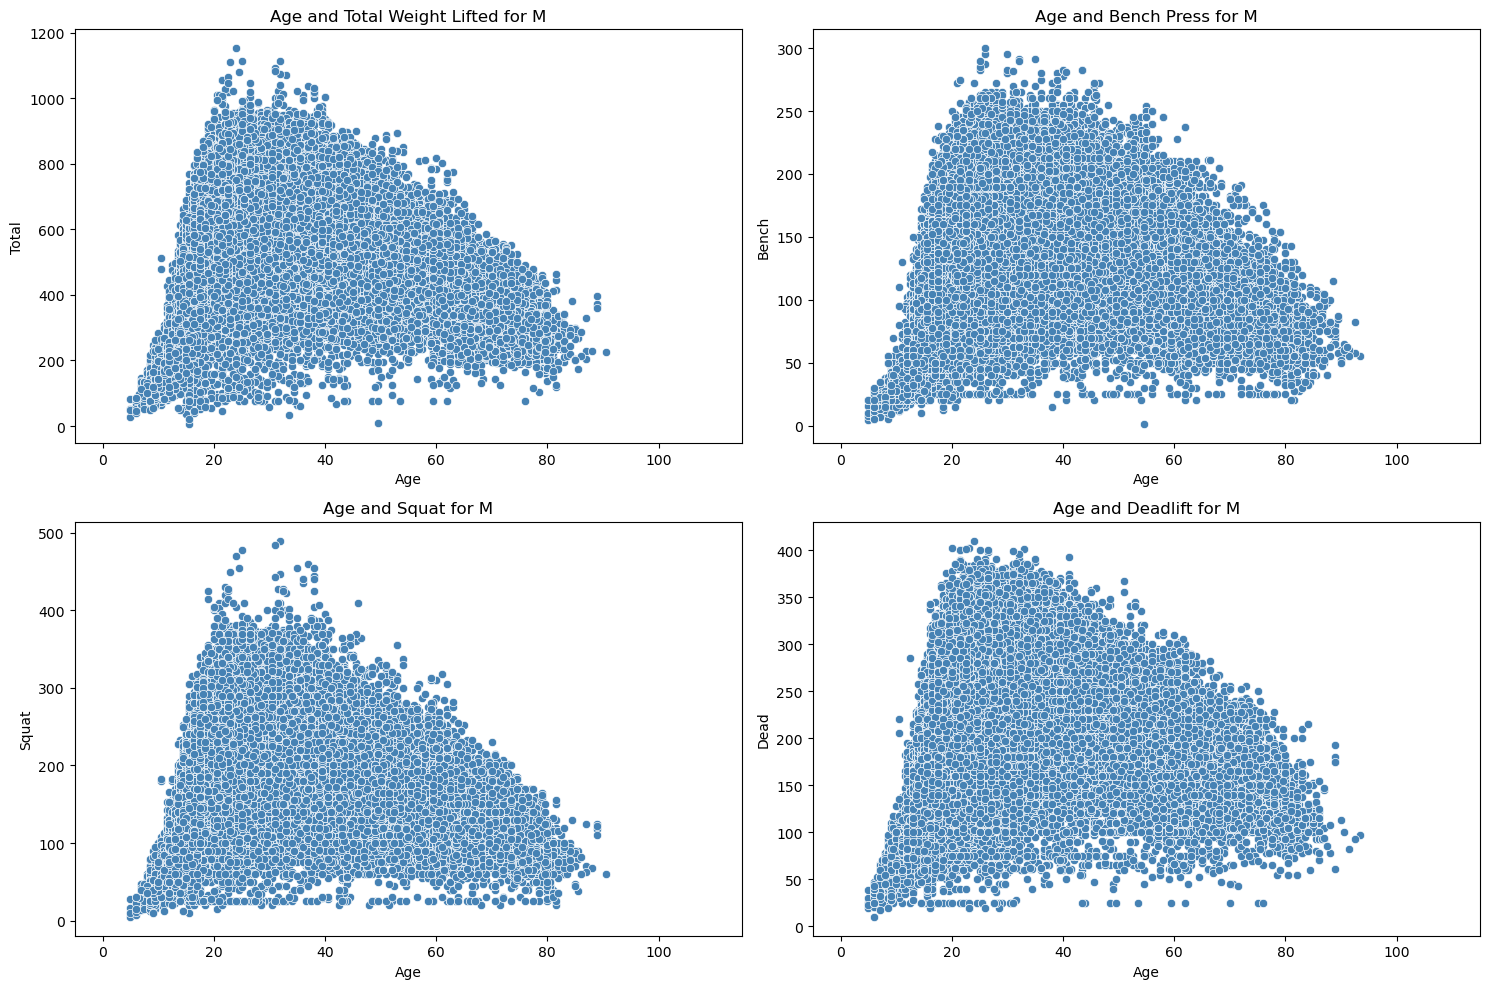

In [7]:
quadrant(total,bench,squat,dead,'M','Scatter')

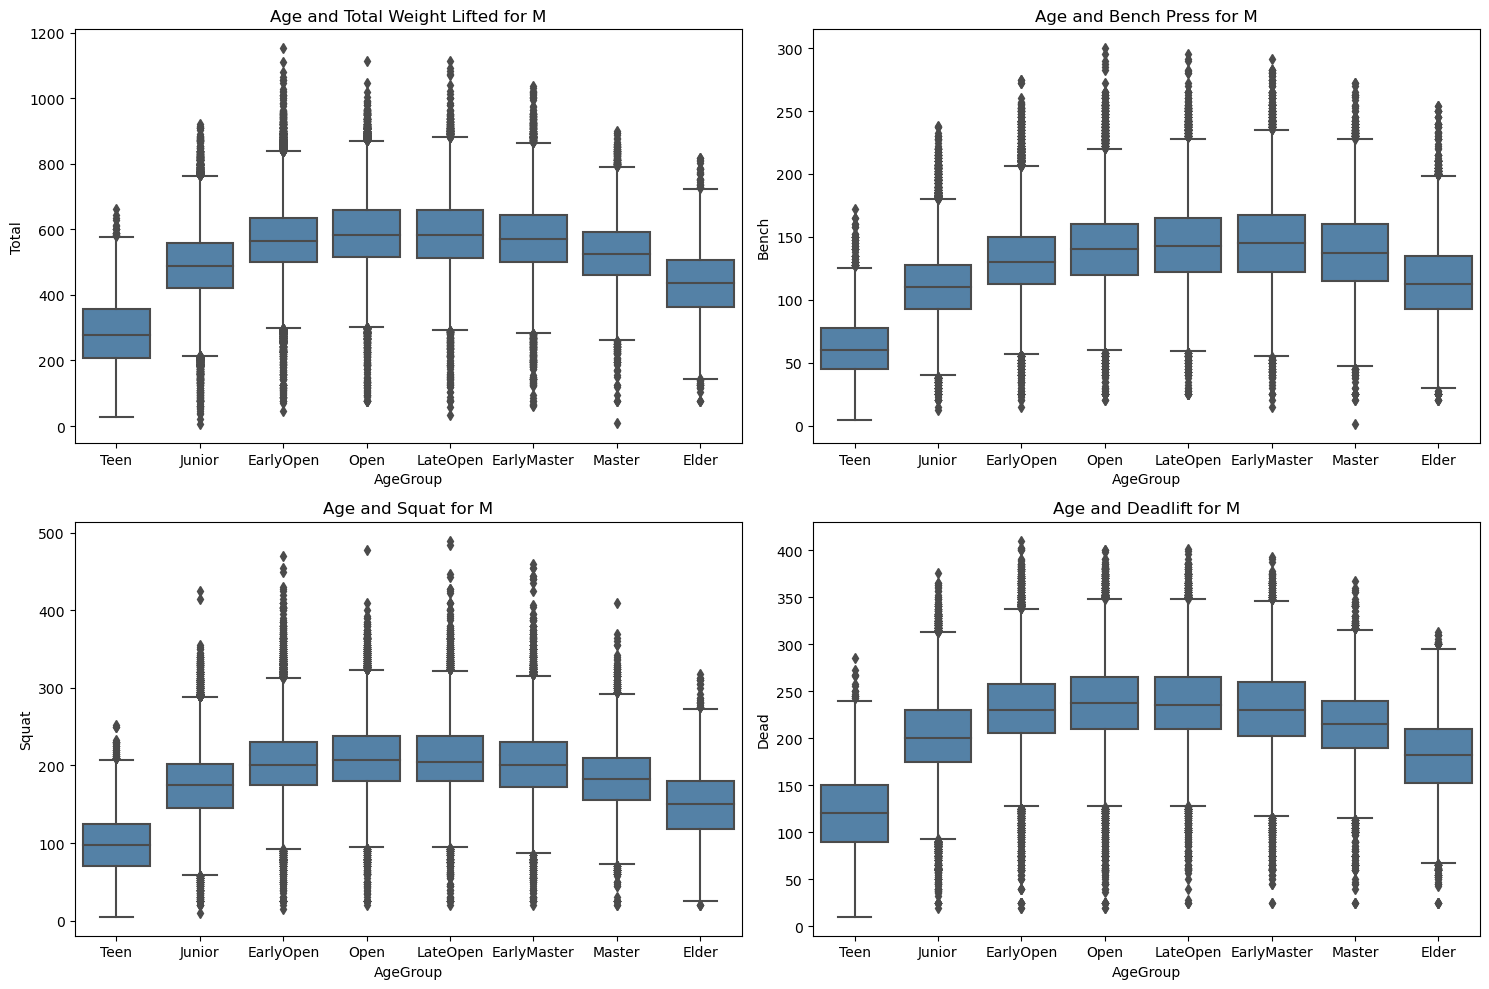

In [8]:
quadrant(total,bench,squat,dead,'M','Box')

Sex = F

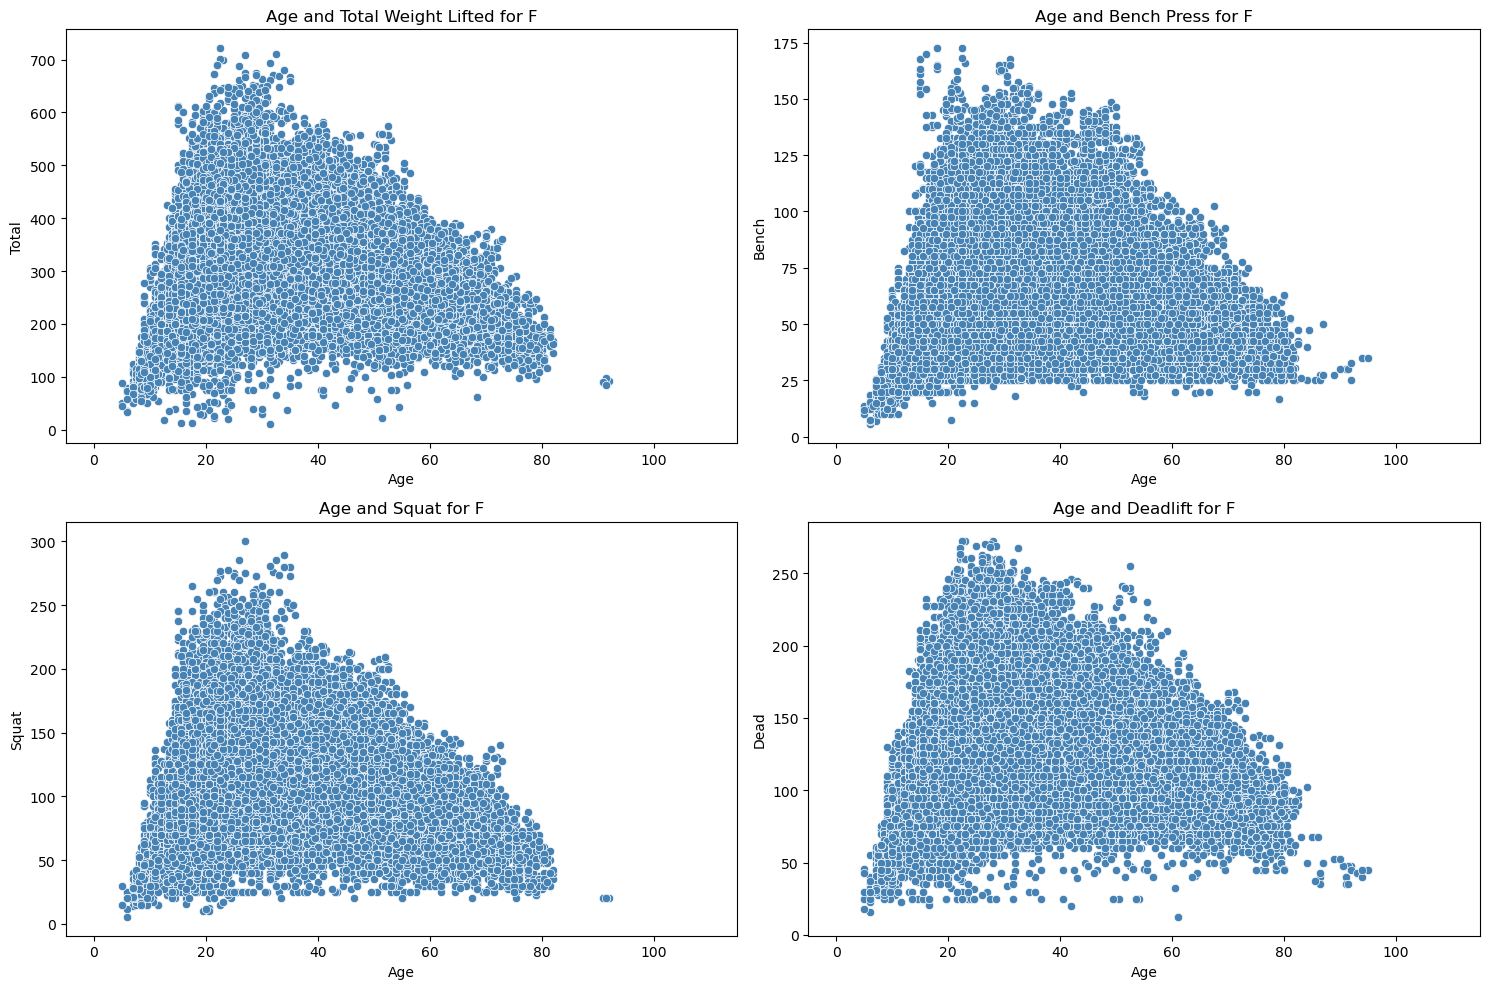

In [9]:
# Female
quadrant(total,bench,squat,dead,'F','Scatter')

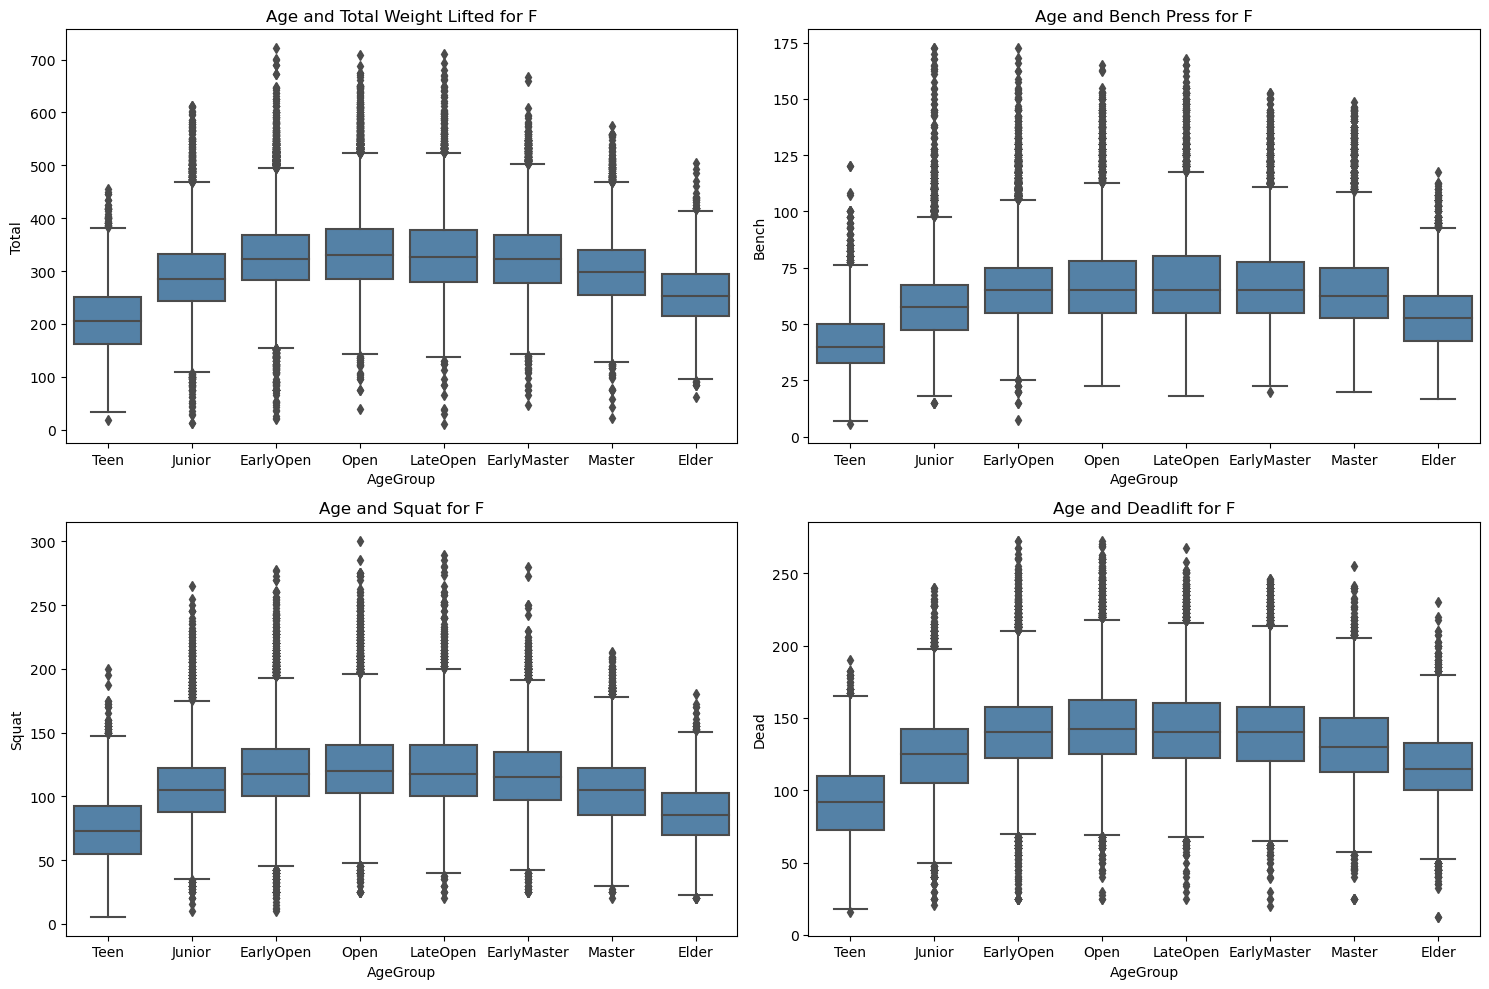

In [10]:
quadrant(total,bench,squat,dead,'F','Box')

Take a random sample for each age group

In [11]:
age_groups = df['AgeGroup'].unique()

def sample(total, n):
    dfs = pd.DataFrame()
    for x in range(len(age_groups)):
        a = total[total['AgeGroup']==age_groups[x]].copy()
        aa = a.sample(n = 500).copy()
        dfs = pd.concat([dfs,aa], axis = 0, ignore_index = True)
    return dfs

Sex = M

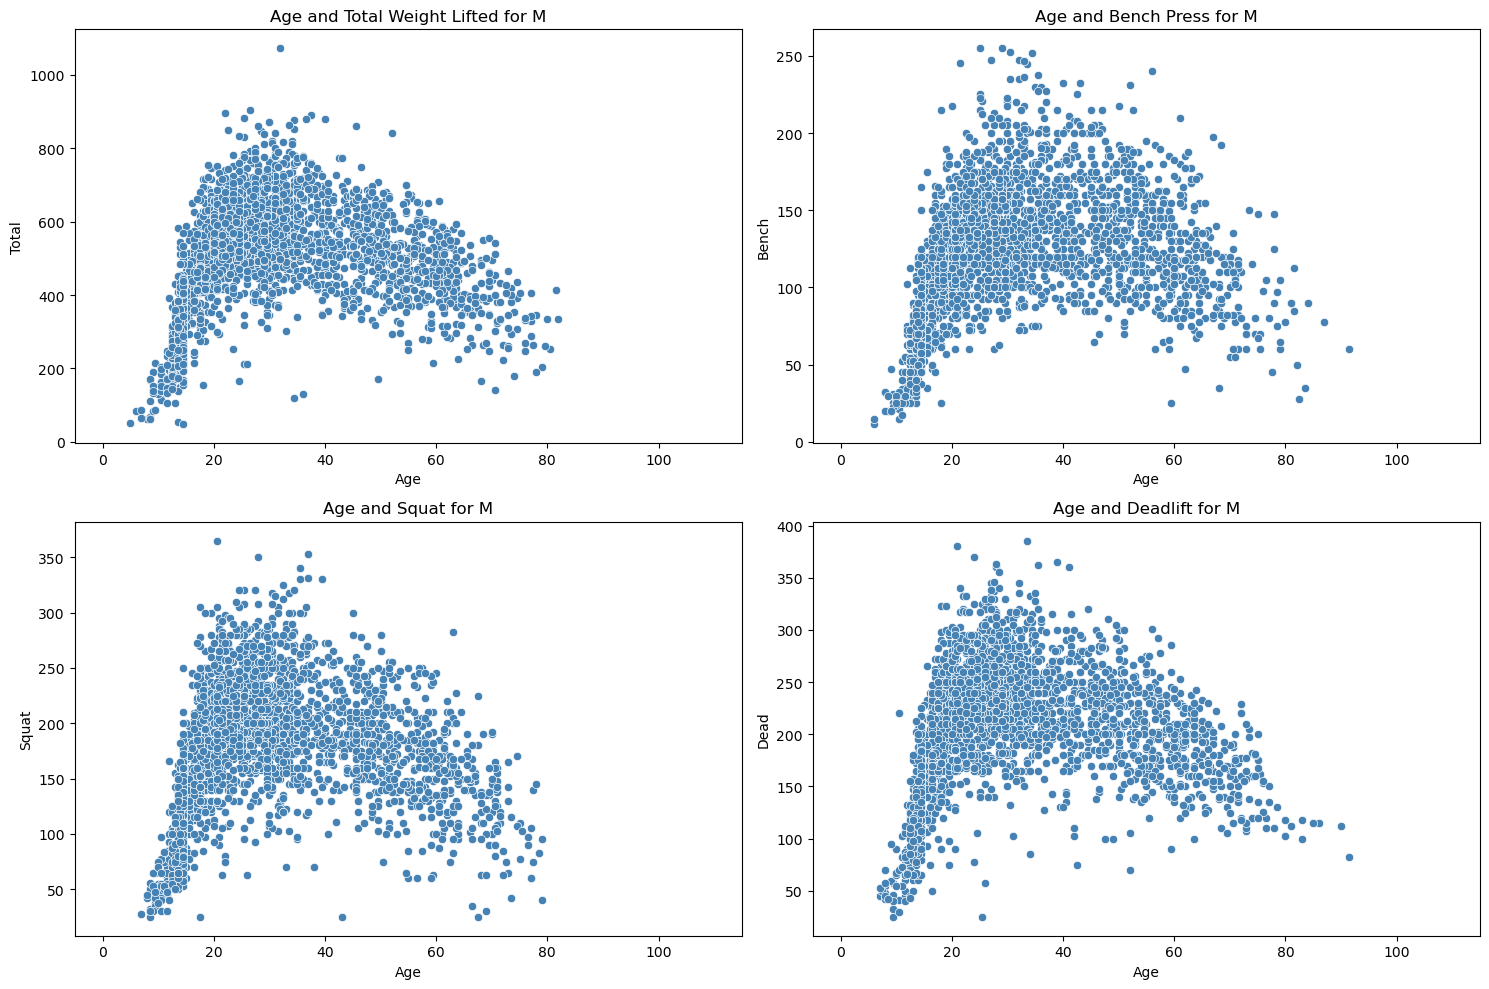

In [12]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Scatter')

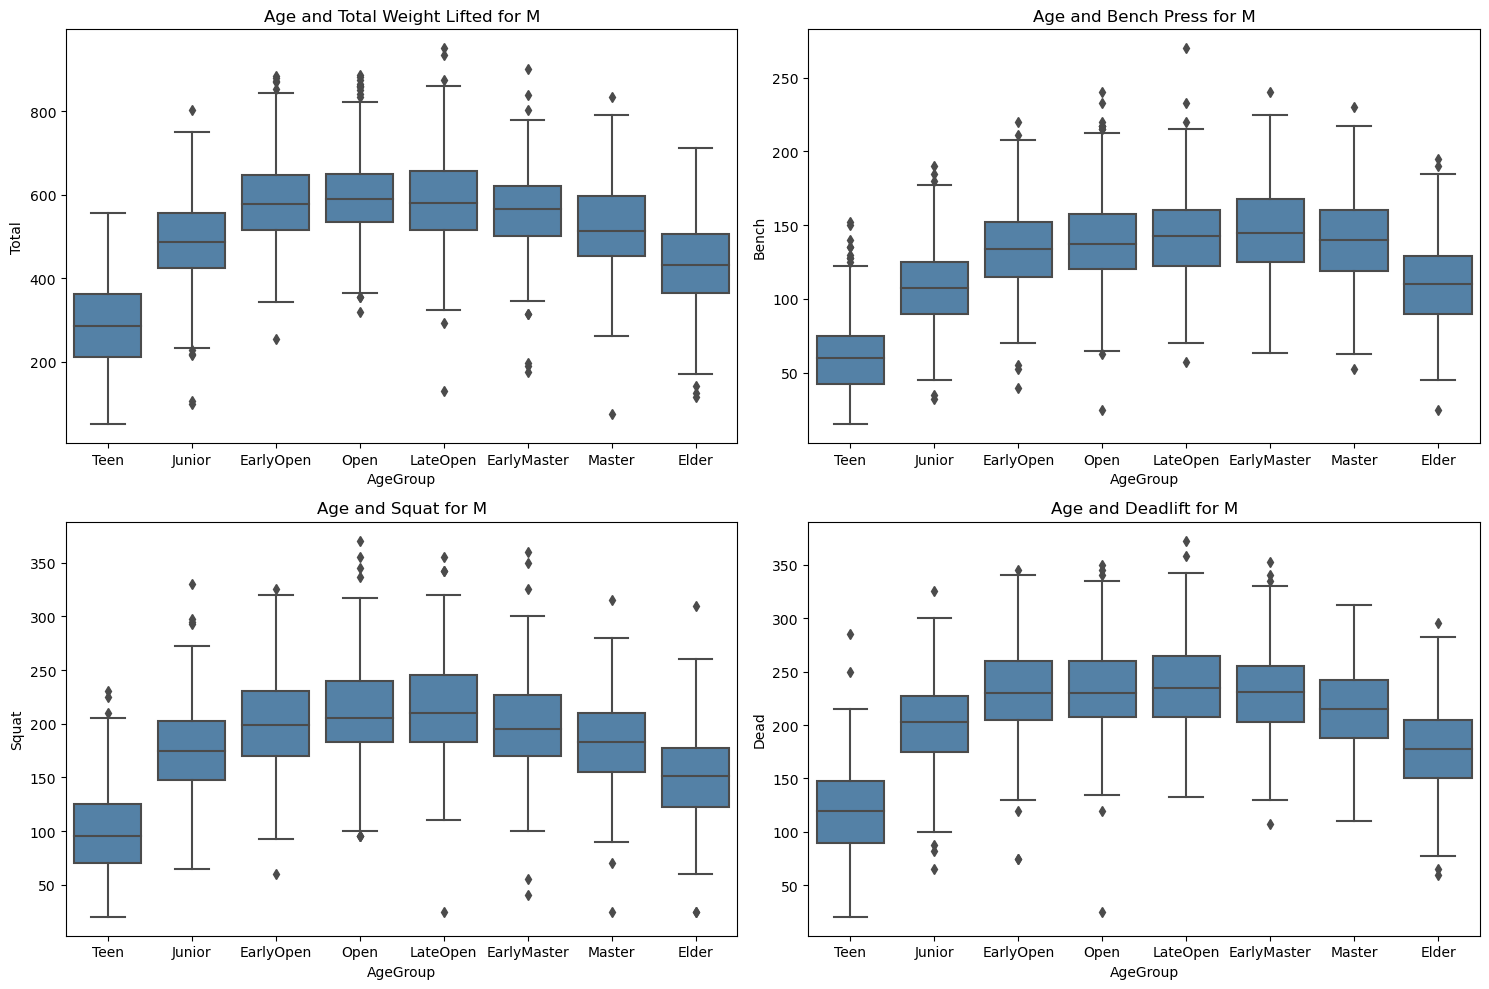

In [13]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Box')

Sex = F

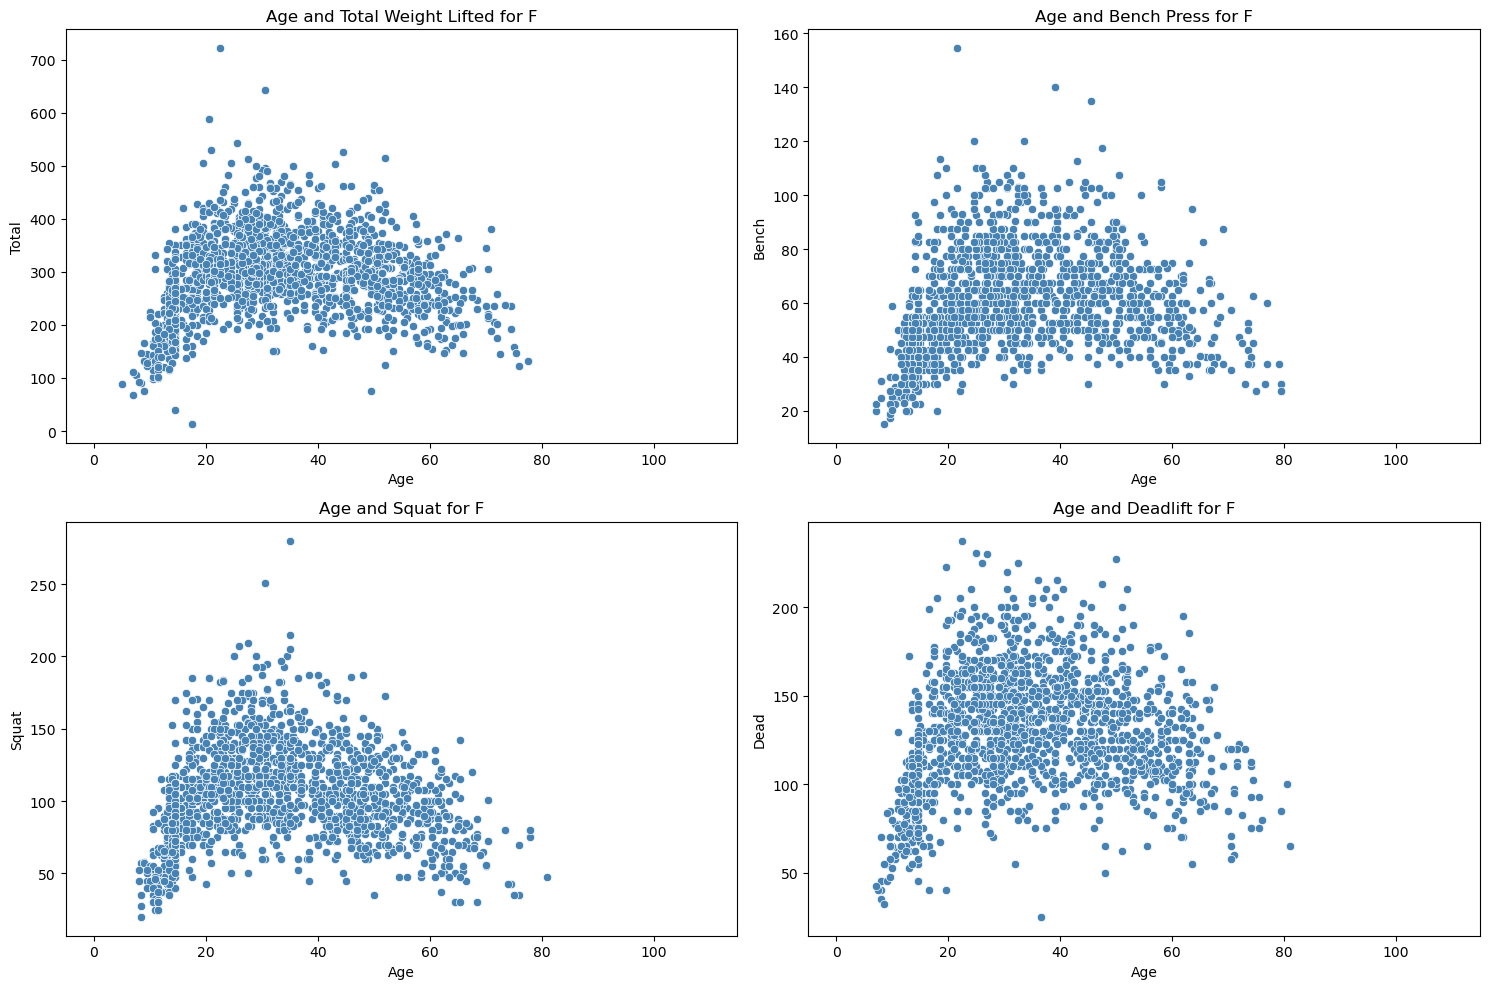

In [14]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Scatter')

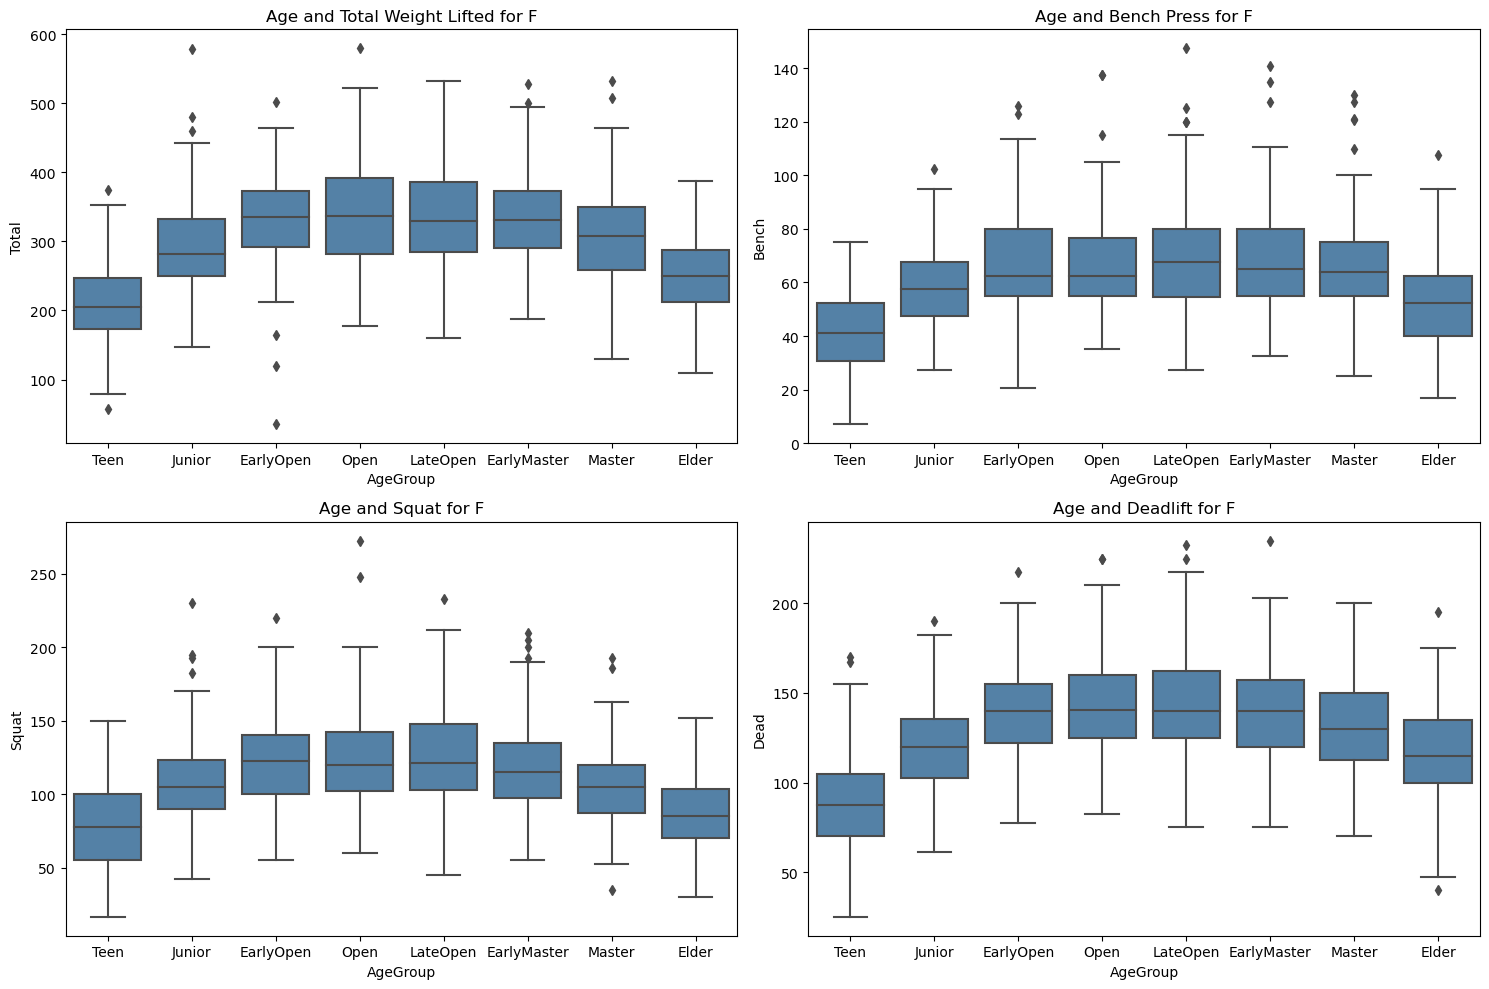

In [15]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Box')

Random Selected Sample Scatter Plot with Hue

In [16]:
def quadrant_hue(total,bench,squat,dead,sex,hue,group):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
    if group == 'Lighter':
        total = total[total['Weight'].isin(['Light','Middle'])]
        dead = dead[dead['Weight'].isin(['Light','Middle'])]
        squat = squat[squat['Weight'].isin(['Light','Middle'])]
        bench = bench[bench['Weight'].isin(['Light','Middle'])]
    elif group == 'Heavier':
        total = total[total['Weight'].isin(['Heavy','SuperHeavy'])]
        dead = dead[dead['Weight'].isin(['Heavy','SuperHeavy'])]
        squat = squat[squat['Weight'].isin(['Heavy','SuperHeavy'])]
        bench = bench[bench['Weight'].isin(['Heavy','SuperHeavy'])]
    
    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)

    hue_order = total[hue].unique()

    palette = sns.color_palette('Accent', n_colors=len(hue_order))

    sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', ax=axs[0, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', ax=axs[0, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', ax=axs[1, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', ax=axs[1, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    plt.tight_layout()

Sex = M

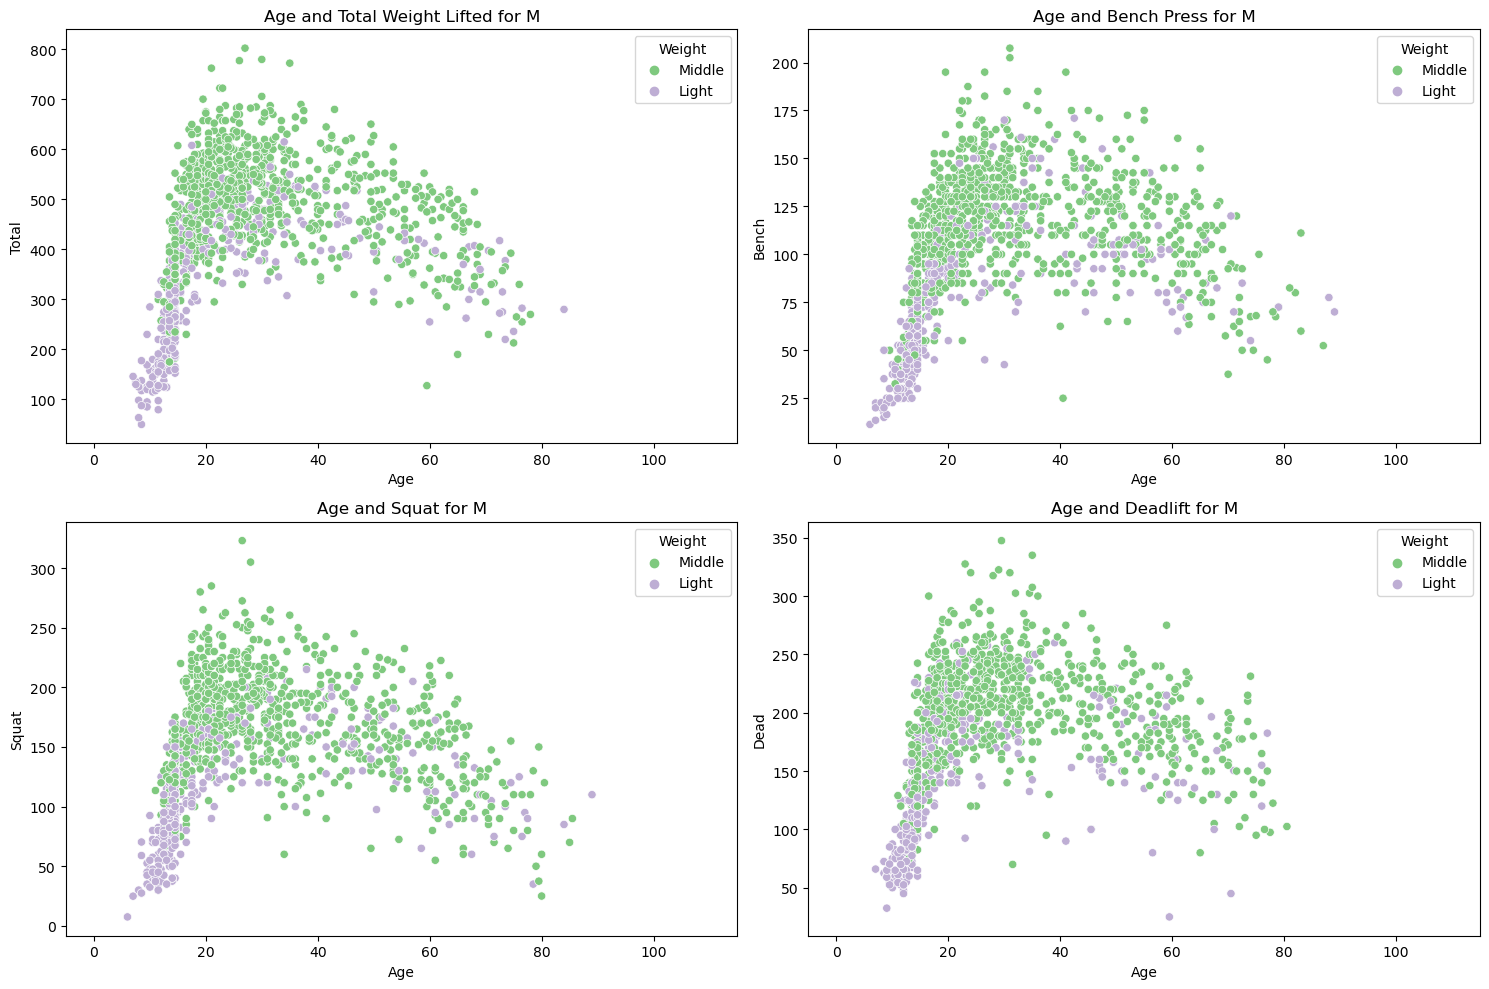

In [17]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Lighter')

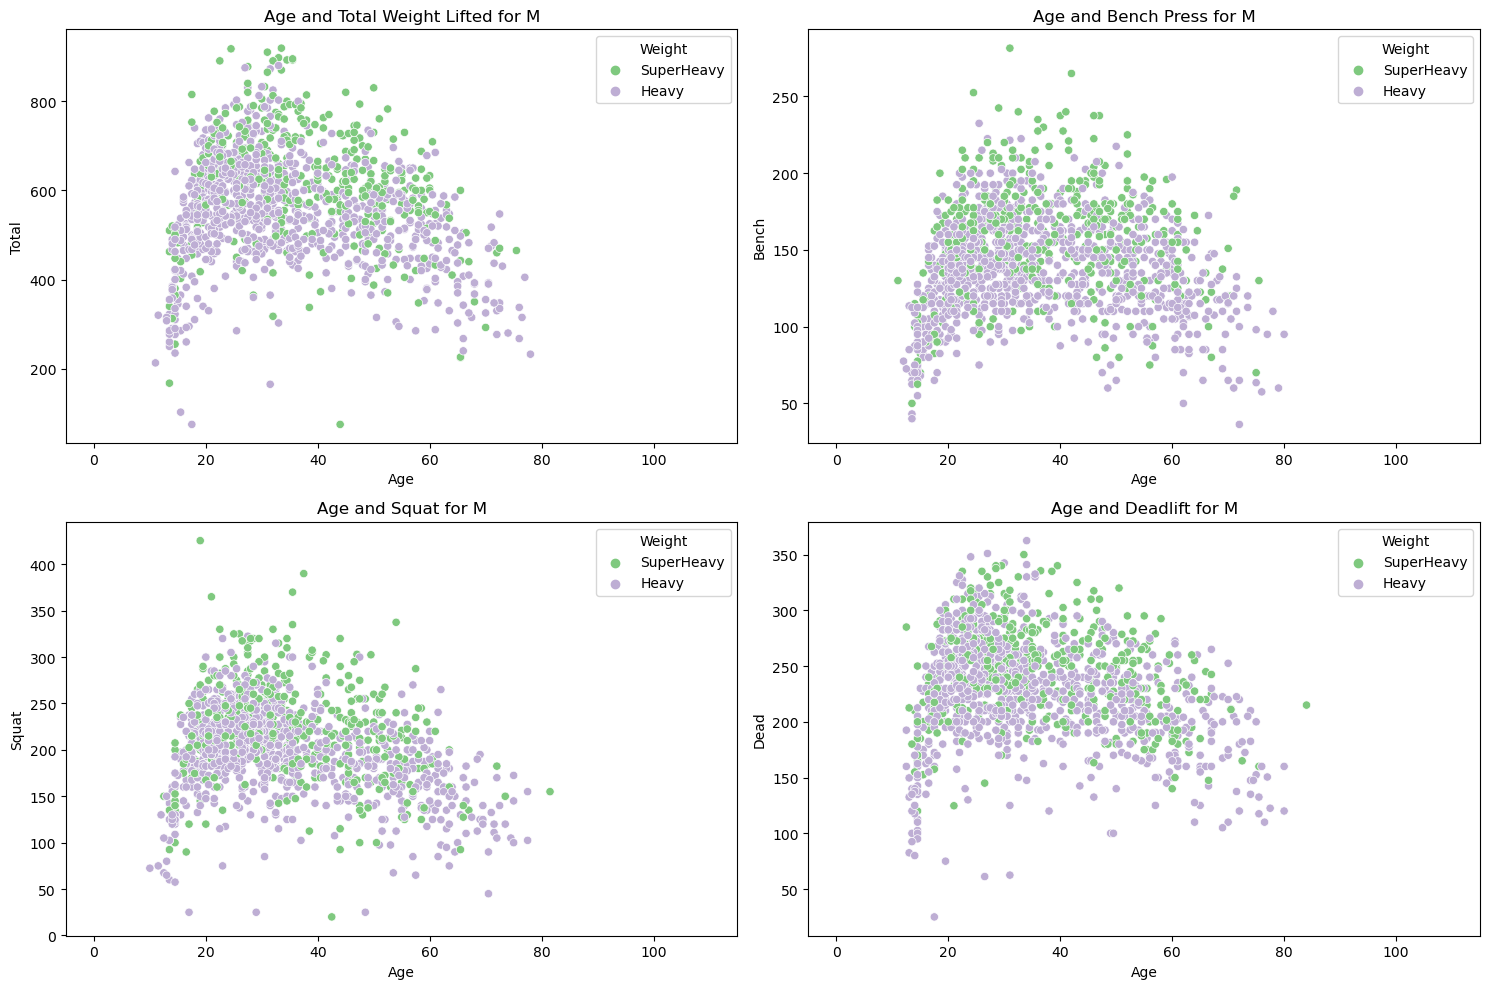

In [18]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Heavier')

Sex = F

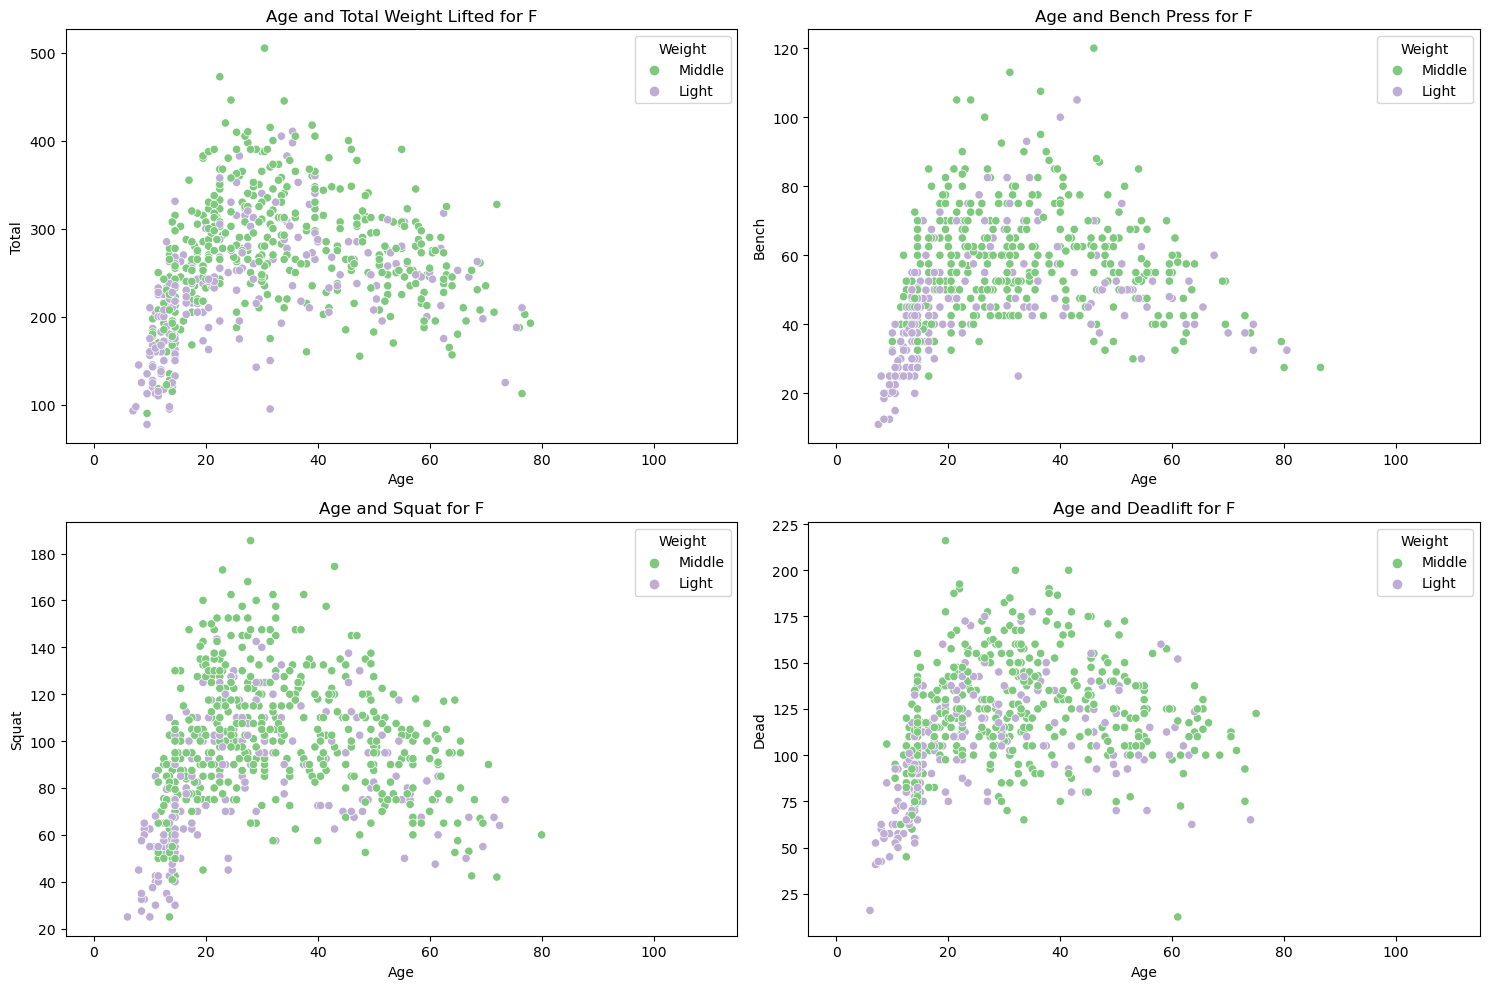

In [19]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Lighter')

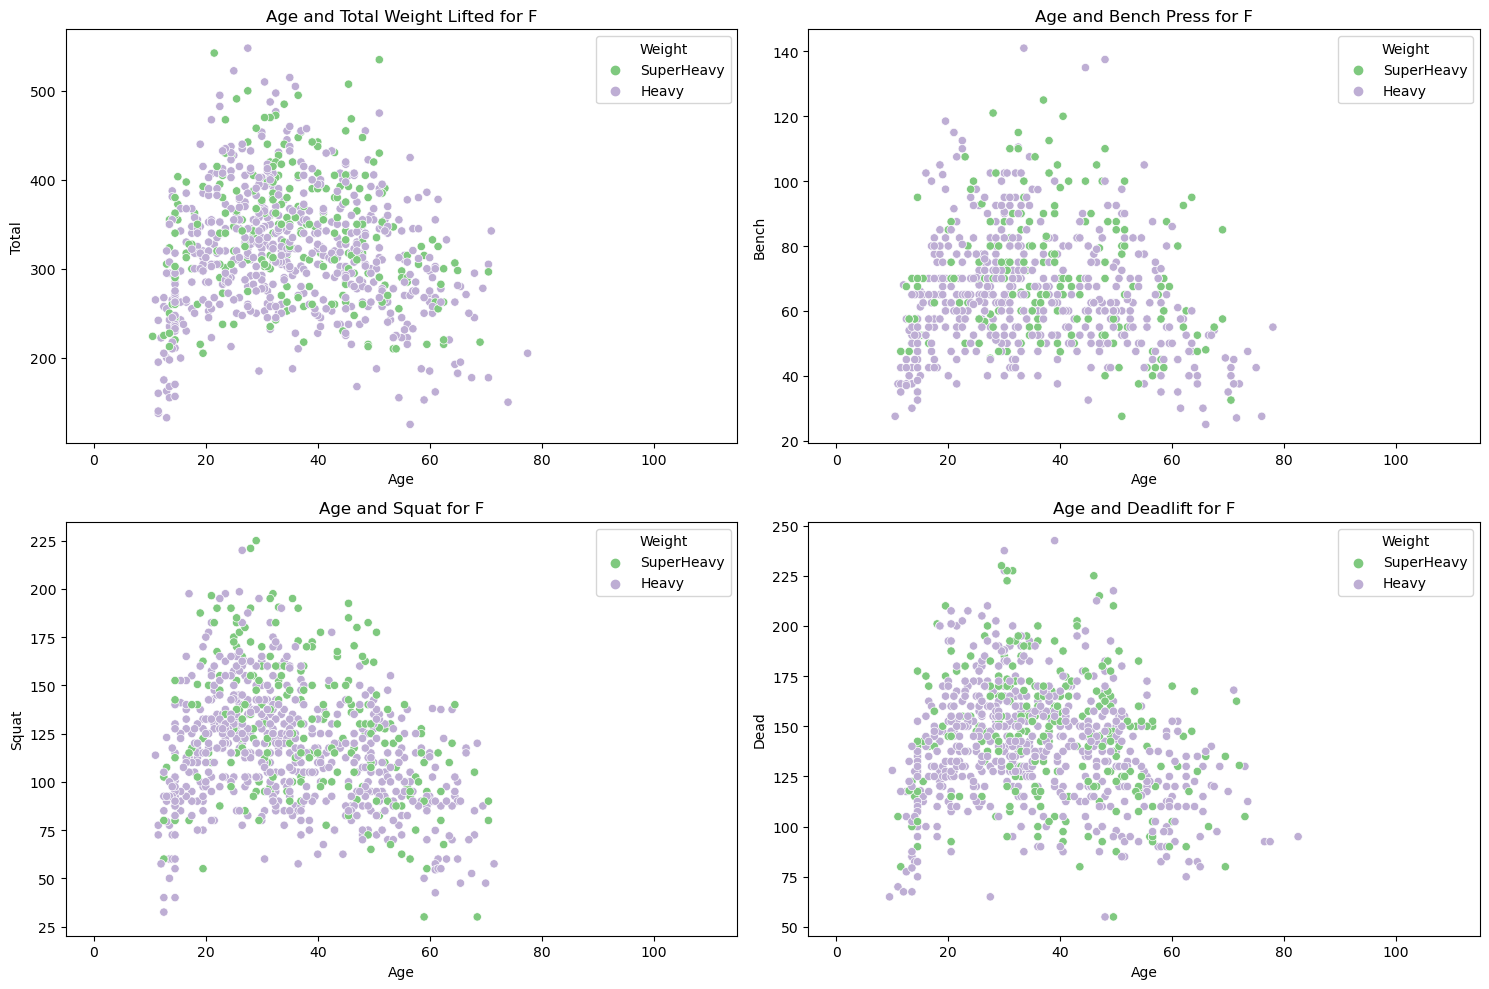

In [20]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Heavier')

# 1) Gaussian Distribution

Explore normality between Age Groups and Peak Strength levels across Total, Bench, Dead, and Squat

In [21]:
def max_strength(total, sex):
    summary = pd.DataFrame()
    col = total.columns[3]
    cutoff = total[total['Sex'] == sex].groupby('AgeGroup')[col].quantile(.9).reset_index().copy()
    return cutoff

def shapiro_wilk(total, sex, alpha):
    a = max_strength(total, sex)
    col = total.columns[3]
    stat, p = stats.shapiro(a[col])
    if p > alpha:
        return 'The data appears to be normally distributed (fail to reject H0)'
    else:
        return 'The data does not appear to be normally distributed (reject H0)'
        
def bar_quadrant(total, bench, squat, dead, sex):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    axs[0, 0].set_title('Top Total per Age Group for ' + sex)
    axs[0, 1].set_title('Top Bench Press per Age Group for ' + sex)
    axs[1, 0].set_title('Top Squat per Age Group for ' + sex)
    axs[1, 1].set_title('Top Deadlift per Age Group for ' + sex)

    sns.barplot(max_strength(total, sex), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
    sns.barplot(max_strength(bench, sex), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
    sns.barplot(max_strength(squat, sex), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
    sns.barplot(max_strength(dead, sex), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
    
    total_conclusion = shapiro_wilk(total, sex, alpha=0.05)
    bench_conclusion = shapiro_wilk(bench, sex, alpha=0.05)
    squat_conclusion = shapiro_wilk(squat, sex, alpha=0.05)
    dead_conclusion = shapiro_wilk(dead, sex, alpha=0.05)
    for ax in axs.flat:
        for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                    round(bar.get_height(), 2), ha='center', va='bottom')
        
    axs[0, 0].text(0.5, -0.2, total_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 0].transAxes, fontsize=10, color='red')
    axs[0, 1].text(0.5, -0.2, bench_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 1].transAxes, fontsize=10, color='red')
    axs[1, 0].text(0.5, -0.2, squat_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 0].transAxes, fontsize=10, color='red')
    axs[1, 1].text(0.5, -0.2, dead_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 1].transAxes, fontsize=10, color='red')

    plt.tight_layout()


Null Hypothesis: The distribution of Top Strength per Age Group is normally distributed.

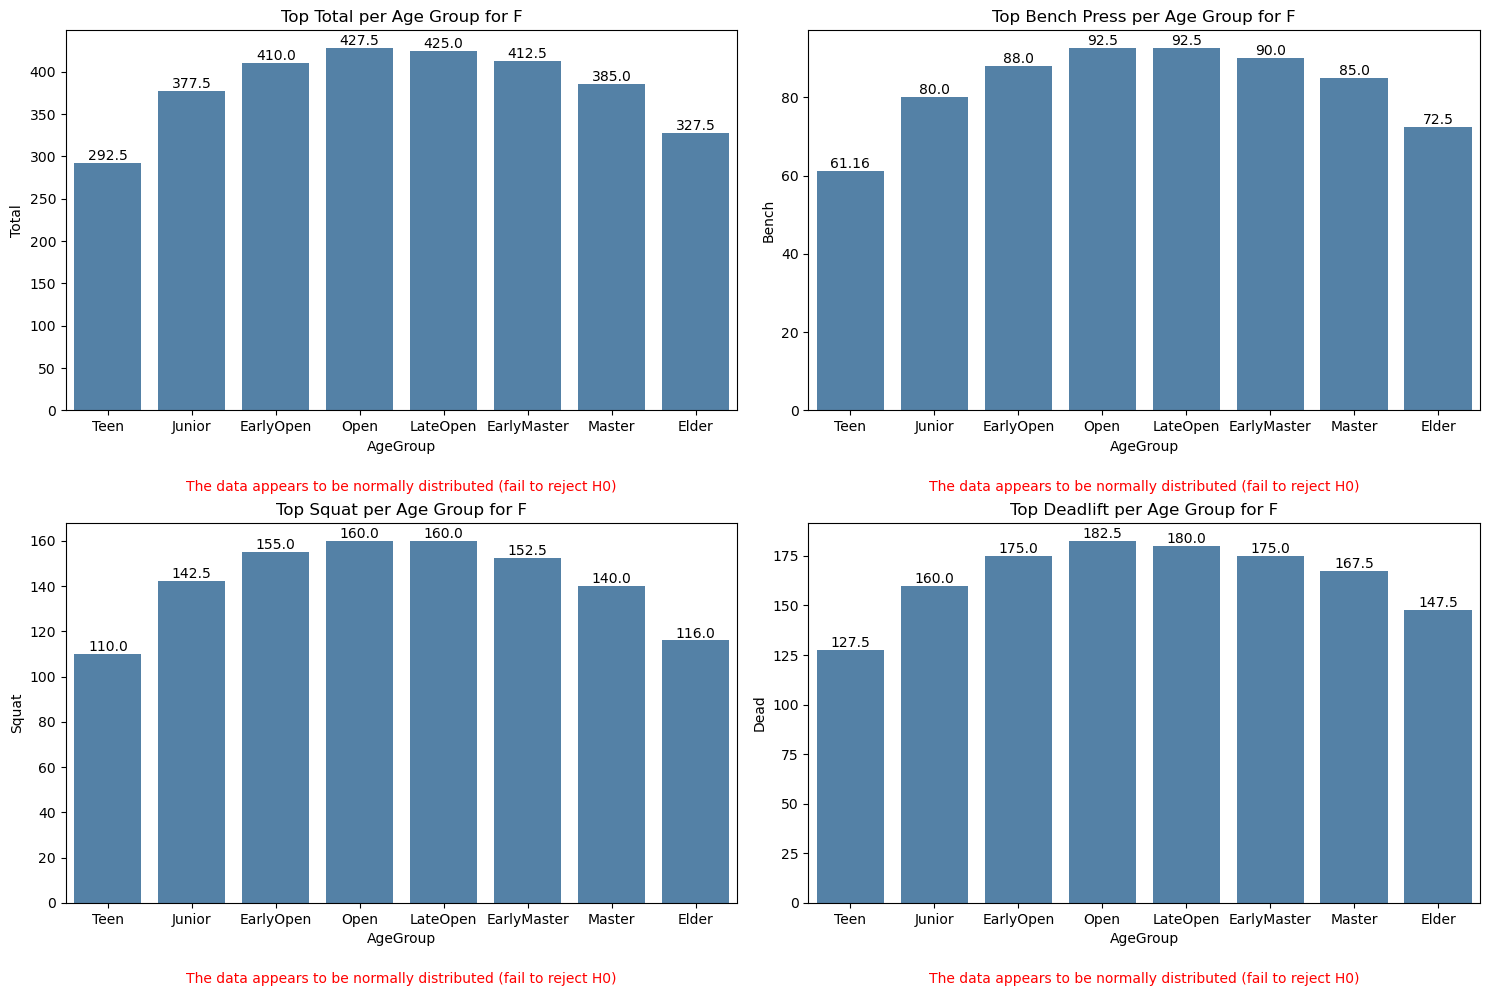

In [22]:
bar_quadrant(total,bench,squat,dead,'F')

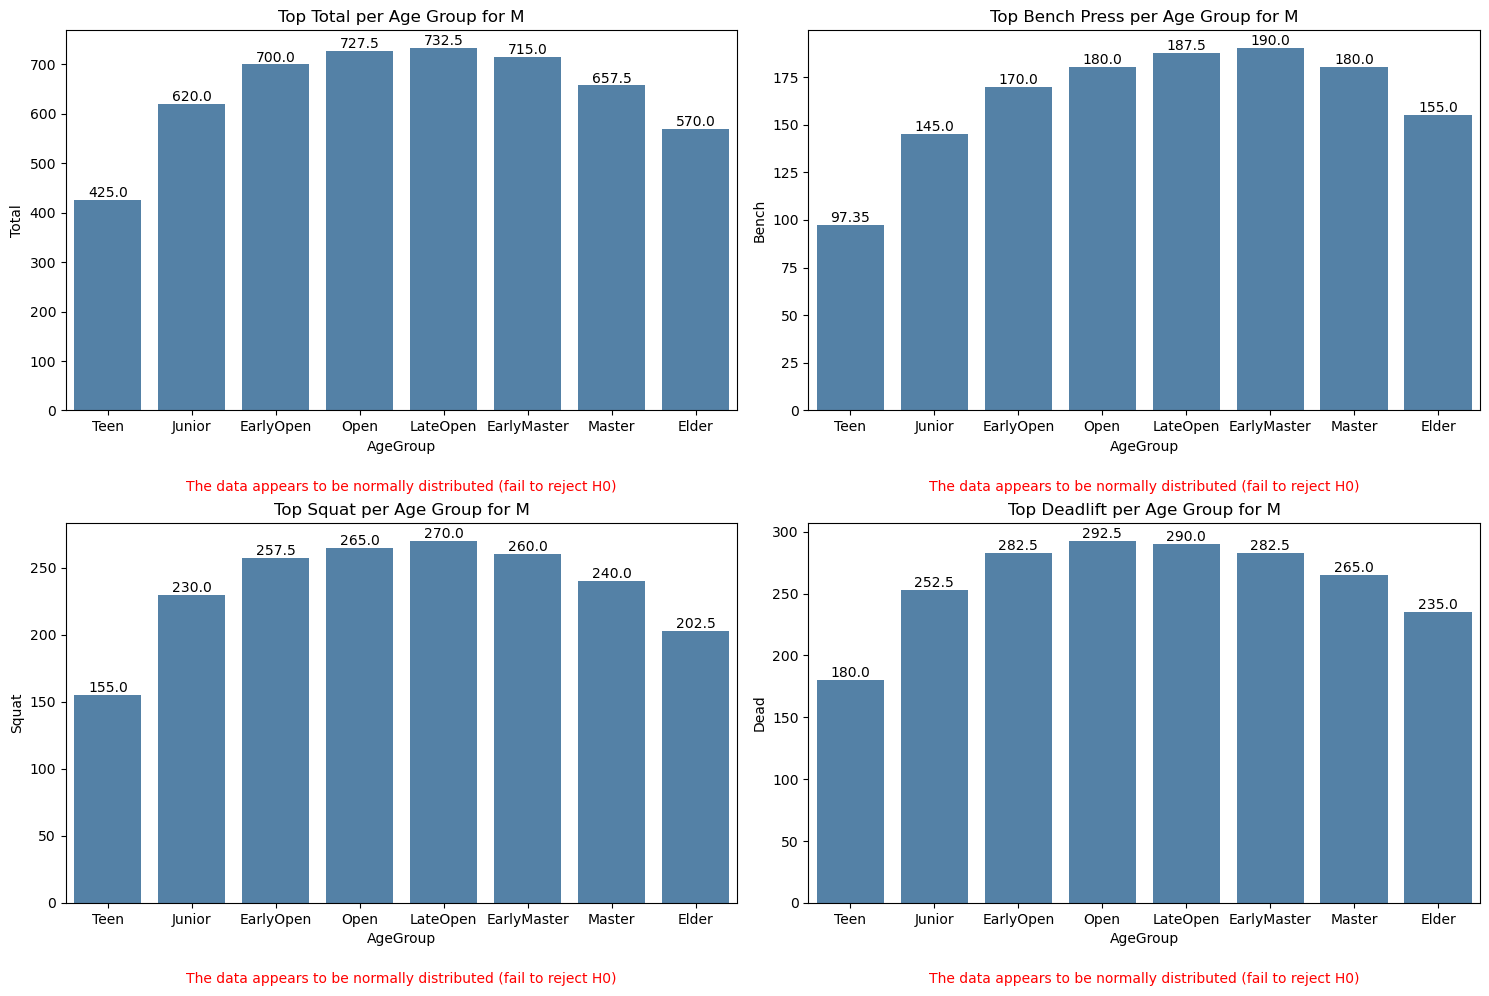

In [23]:
bar_quadrant(total,bench,squat,dead,'M')

# 2) Descriptive Statistical Testing

Top 10% of Total, Bench, Dead, and Squat for each Weight Group
- Statistical testing for difference in means in the top lifters per each weight class

In [24]:
def max_strength_df(total, sex):
    summary = pd.DataFrame()
    col = total.columns[3]
    cutoff = total[total['Sex'] == sex].groupby('Weight')[col].quantile(.9).reset_index().copy()
    for x in range(len(cutoff)):
        weight = cutoff.iloc[x,0]
        strength = cutoff.iloc[x,1]
        df = total[total['Sex'] == sex][(total[total['Sex'] == sex]['Weight']==weight)&(total[total['Sex'] == sex][col]>=strength)].copy()
        summary = pd.concat([summary, df], axis = 0, ignore_index = True)
    return summary

def mean_age_difference_z_test(total, sex, alpha):
    results = {}
    df = max_strength_df(total, sex)
    weight_groups = df['Weight'].unique()
    
    for i in range(len(weight_groups)):
        for j in range(i + 1, len(weight_groups)):
            group1 = weight_groups[i]
            group2 = weight_groups[j]
            sample1 = df[(df['Weight'] == group1) & (df['Sex'] == sex)]['Age']
            sample2 = df[(df['Weight'] == group2) & (df['Sex'] == sex)]['Age']
            z_stat, p_value = ztest(sample1, sample2)

            p_value_formatted = '{:.5f}'.format(p_value) 
            
            if p_value < alpha:
                decision = 'Reject H0: There is a significant difference'
            else:
                decision = 'Fail to reject H0: There is no significant difference'
            
            results[f'{group1} vs {group2}'] = {'Z statistic': z_stat,
                                                 'p-value': p_value_formatted,
                                                 'Decision': decision}
    print(df.groupby('Weight')['Age'].describe())
    return results

def mean_weight_age_z_test(total, sex, alpha):
    results = {}
    df = max_strength_df(total, sex)
    df = df[df['AgeGroup']!='Teen']
    age_groups = df['AgeGroup'].unique()
    col = df.columns[3]
    top_age = df.groupby('AgeGroup')[col].mean().idxmax()
    age_groups = [x for x in age_groups if (x != top_age)]
    sample1 = df[(df['AgeGroup'] == top_age) & (df['Sex'] == sex)][col]
    for i in range(len(age_groups)):
        group2 = age_groups[i]
        sample2 = df[(df['AgeGroup'] == group2) & (df['Sex'] == sex)][col]
        z_stat, p_value = ztest(sample1, sample2)

        p_value_formatted = '{:.5f}'.format(p_value) 

        if p_value < alpha:
            decision = 'Reject H0: There is a significant difference'
        else:
            decision = 'Fail to reject H0: There is no significant difference'

        results[f'{top_age} vs {group2}'] = {'Z statistic': z_stat,
                                             'p-value': p_value_formatted,
                                             'Decision': decision}
    print(df.groupby('AgeGroup')[col].describe())
    return results

Null hypothesis: The mean weight lifted, in peak lifters, of the strongest Age Group is not different than the other Age Groups

Total Weight Lifted

In [25]:
mean_weight_age_z_test(total, 'F', .05)

              count        mean        std    min    25%    50%    75%    max
AgeGroup                                                                     
Teen            0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN
Junior       1011.0  429.926686  50.458177  335.0  392.5  423.5  457.5  612.5
EarlyOpen    4180.0  429.112136  50.669013  335.0  392.5  422.5  458.0  721.5
Open         3656.0  438.181723  55.025300  335.0  400.0  430.5  467.5  708.0
LateOpen     2159.0  438.031510  53.554504  335.0  400.0  432.0  470.0  710.0
EarlyMaster  1898.0  438.419231  50.077235  335.0  405.0  435.0  470.0  667.5
Master        475.0  439.626947  46.060809  335.0  412.5  432.5  470.0  575.0
Elder          37.0  406.662162  42.305118  338.0  382.5  410.0  425.0  505.0


{'Master vs Open': {'Z statistic': 0.5480081079064826,
  'p-value': '0.58369',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Master vs EarlyOpen': {'Z statistic': 4.3242338420574695,
  'p-value': '0.00002',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs LateOpen': {'Z statistic': 0.602106922790531,
  'p-value': '0.54710',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Master vs Junior': {'Z statistic': 3.5517816415888634,
  'p-value': '0.00038',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs EarlyMaster': {'Z statistic': 0.4774853631654237,
  'p-value': '0.63302',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Master vs Elder': {'Z statistic': 4.216406063439694,
  'p-value': '0.00002',
  'Decision': 'Reject H0: There is a significant difference'}}

In [26]:
mean_weight_age_z_test(total, 'M', .05)

              count        mean        std    min    25%     50%     75%  \
AgeGroup                                                                   
Teen            0.0         NaN        NaN    NaN    NaN     NaN     NaN   
Junior       2005.0  674.094913  76.557976  527.5  632.5  665.00  720.00   
EarlyOpen    9858.0  703.075956  80.865565  527.5  647.5  705.00  750.00   
Open         7081.0  720.412596  82.992401  527.5  660.0  719.00  777.50   
LateOpen     3519.0  731.646317  87.682869  527.5  670.0  727.50  792.50   
EarlyMaster  2180.0  729.471706  93.532719  527.5  665.0  727.50  792.50   
Master        373.0  708.554155  92.561249  527.5  645.0  710.00  785.00   
Elder          52.0  693.341538  73.543763  535.0  645.0  691.25  751.25   

                max  
AgeGroup             
Teen            NaN  
Junior        920.5  
EarlyOpen    1152.5  
Open         1113.0  
LateOpen     1112.5  
EarlyMaster  1037.5  
Master        900.0  
Elder         817.5  


{'LateOpen vs Open': {'Z statistic': 6.43974950997304,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyOpen': {'Z statistic': 17.58999325567945,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Master': {'Z statistic': 4.810225256357509,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyMaster': {'Z statistic': 0.8868398947783447,
  'p-value': '0.37517',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'LateOpen vs Elder': {'Z statistic': 3.1338382991768734,
  'p-value': '0.00173',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Junior': {'Z statistic': 24.539571967609703,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Squat

In [27]:
mean_weight_age_z_test(squat, 'F', .05)

              count        mean        std    min     25%    50%     75%  \
AgeGroup                                                                   
Teen            0.0         NaN        NaN    NaN     NaN    NaN     NaN   
Junior       1359.0  161.151229  23.363586  120.0  144.00  157.5  175.00   
EarlyOpen    4689.0  159.514142  22.589871  120.0  142.50  157.5  172.50   
Open         3729.0  163.740829  24.879839  120.0  145.00  160.0  177.50   
LateOpen     2097.0  163.686686  24.798229  120.0  145.00  160.0  180.00   
EarlyMaster  1764.0  164.264512  22.518420  120.0  147.50  162.5  180.00   
Master        411.0  163.798808  20.039681  120.0  150.00  160.0  180.00   
Elder          15.0  152.200000  16.954561  120.5  141.75  155.0  161.25   

               max  
AgeGroup            
Teen           NaN  
Junior       265.0  
EarlyOpen    277.5  
Open         300.5  
LateOpen     289.0  
EarlyMaster  280.0  
Master       213.0  
Elder        180.0  


{'EarlyMaster vs Open': {'Z statistic': 0.7504980354165041,
  'p-value': '0.45295',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 7.535246700800108,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 3.7683037326364786,
  'p-value': '0.00016',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 0.7519945134919324,
  'p-value': '0.45205',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 0.38521972292530227,
  'p-value': '0.70007',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 2.069765017428405,
  'p-value': '0.03847',
  'Decision': 'Reject H0: There is a significant difference'}}

In [28]:
mean_weight_age_z_test(squat, 'M', .05)

               count        mean        std    min    25%    50%    75%    max
AgeGroup                                                                      
Teen             0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN
Junior        3023.0  247.380490  32.382743  187.5  227.5  242.5  265.0  425.5
EarlyOpen    11085.0  257.783380  34.137922  187.5  232.5  257.5  275.0  470.0
Open          7129.0  263.842352  34.739398  187.5  238.0  260.5  285.0  478.0
LateOpen      3463.0  269.440606  38.045694  187.5  242.5  265.0  295.0  490.0
EarlyMaster   2326.0  270.212816  39.933281  187.5  240.0  265.0  295.0  460.0
Master         441.0  262.259229  36.943696  187.5  235.0  260.0  290.0  410.0
Elder           69.0  253.948406  30.307408  187.5  232.5  255.0  265.0  317.5


{'EarlyMaster vs Open': {'Z statistic': 7.392950558751127,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 15.47792082581518,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 0.74210256192149,
  'p-value': '0.45803',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 3.879590050127033,
  'p-value': '0.00010',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 23.083736236639893,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 3.354378828468265,
  'p-value': '0.00080',
  'Decision': 'Reject H0: There is a significant difference'}}

Bench

In [29]:
mean_weight_age_z_test(bench, 'F', .05)

              count        mean        std   min   25%    50%    75%     max
AgeGroup                                                                    
Teen            0.0         NaN        NaN   NaN   NaN    NaN    NaN     NaN
Junior       1516.0   94.629426  14.560446  72.5  85.0   92.5  100.0  172.37
EarlyOpen    4981.0   94.517266  13.263947  72.5  85.0   92.5  102.5  172.50
Open         4092.0   96.284066  14.115478  72.5  85.0   95.0  102.5  165.00
LateOpen     2783.0   98.154592  15.567663  72.5  87.5   95.0  105.0  167.50
EarlyMaster  3163.0   96.920487  14.054017  72.5  87.5   95.0  105.0  152.50
Master       1280.0  100.518594  15.865545  72.5  90.0  100.0  110.0  148.50
Elder         189.0   93.804497   9.898670  72.5  87.5   93.0  102.5  117.50


{'Master vs Open': {'Z statistic': 9.086668840835765,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs EarlyOpen': {'Z statistic': 13.841943774936038,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs LateOpen': {'Z statistic': 4.4692657934842925,
  'p-value': '0.00001',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs Junior': {'Z statistic': 10.225918788206915,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs EarlyMaster': {'Z statistic': 7.440007066262906,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs Elder': {'Z statistic': 5.656595447999392,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [30]:
mean_weight_age_z_test(bench, 'M', .05)

              count        mean        std    min    25%    50%    75%     max
AgeGroup                                                                      
Teen            0.0         NaN        NaN    NaN    NaN    NaN    NaN     NaN
Junior       1955.0  165.447182  22.175214  127.5  152.5  162.5  180.0  238.14
EarlyOpen    8933.0  173.659301  23.295313  127.5  157.5  175.0  187.5  275.00
Open         8119.0  180.380345  24.778685  127.5  162.5  180.0  197.5  300.00
LateOpen     5832.0  184.600907  25.911863  127.5  165.0  182.5  202.5  295.00
EarlyMaster  6506.0  188.897263  26.059385  127.5  175.0  187.5  205.0  291.50
Master       2324.0  186.262694  26.355193  127.5  165.0  185.0  205.0  272.50
Elder         521.0  181.479079  26.485492  127.5  160.5  180.0  200.0  254.01


{'EarlyMaster vs Open': {'Z statistic': 20.18623866401504,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 38.162807220358474,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 9.167298549480574,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 4.170992928579395,
  'p-value': '0.00003',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 6.244462334890931,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 36.05777055560442,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Dead

In [31]:
mean_weight_age_z_test(dead, 'F', .05)

              count        mean        std    min      25%     50%      75%  \
AgeGroup                                                                      
Teen            0.0         NaN        NaN    NaN      NaN     NaN      NaN   
Junior       1007.0  181.100159  17.325366  145.0  170.000  180.00  190.505   
EarlyOpen    4364.0  181.950543  19.121402  145.0  167.500  182.25  192.500   
Open         3958.0  186.011064  20.308586  145.0  172.500  185.00  197.375   
LateOpen     2377.0  185.701552  20.449619  145.0  170.000  185.00  197.500   
EarlyMaster  2486.0  185.099907  19.733800  145.0  172.125  185.00  195.030   
Master        690.0  184.326261  17.224036  145.0  171.000  182.50  192.500   
Elder          90.0  178.961444  19.190535  145.0  162.625  180.00  192.500   

               max  
AgeGroup            
Teen           NaN  
Junior       240.0  
EarlyOpen    272.5  
Open         272.5  
LateOpen     267.5  
EarlyMaster  246.0  
Master       255.0  
Elder        230.0  

{'Open vs EarlyOpen': {'Z statistic': 9.392758662588664,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Open vs EarlyMaster': {'Z statistic': 1.7723491666769515,
  'p-value': '0.07634',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Open vs LateOpen': {'Z statistic': 0.585792083735042,
  'p-value': '0.55802',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Open vs Elder': {'Z statistic': 3.260145089965446,
  'p-value': '0.00111',
  'Decision': 'Reject H0: There is a significant difference'},
 'Open vs Junior': {'Z statistic': 7.048547674338012,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Open vs Master': {'Z statistic': 2.0541474680251812,
  'p-value': '0.03996',
  'Decision': 'Reject H0: There is a significant difference'}}

In [32]:
mean_weight_age_z_test(dead, 'M', .05)

               count        mean        std    min    25%     50%    75%  \
AgeGroup                                                                   
Teen             0.0         NaN        NaN    NaN    NaN     NaN    NaN   
Junior        2584.0  274.108220  29.083857  220.0  260.0  275.00  292.5   
EarlyOpen    10936.0  287.334084  29.776484  220.0  267.5  290.00  305.0   
Open          7768.0  293.121381  29.773286  220.0  272.5  292.50  312.5   
LateOpen      3772.0  295.856339  30.741089  220.0  275.0  297.50  315.0   
EarlyMaster   2552.0  294.848472  30.890091  220.0  275.0  297.50  315.0   
Master         560.0  284.868839  29.583425  220.0  265.0  290.00  305.0   
Elder           98.0  277.159490  19.472668  220.0  268.5  276.25  290.0   

               max  
AgeGroup            
Teen           NaN  
Junior       375.5  
EarlyOpen    410.0  
Open         400.5  
LateOpen     401.0  
EarlyMaster  392.5  
Master       367.5  
Elder        312.5  


{'LateOpen vs EarlyOpen': {'Z statistic': 15.030863508649503,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Master': {'Z statistic': 7.930432048202014,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Open': {'Z statistic': 4.579545279900621,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyMaster': {'Z statistic': 1.2766282167026985,
  'p-value': '0.20173',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'LateOpen vs Elder': {'Z statistic': 5.989324153515446,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Junior': {'Z statistic': 28.31437034647744,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Null Hypothesis: The mean Age of the top lifters in all Weight Groups of the same Sex are not different.

Total Weight Lifted

In [33]:
mean_age_difference_z_test(total,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       9573.0  26.888332  6.292400  16.0  22.5  25.5  30.0  63.0
Light       2609.0  26.083365  7.001345  15.0  21.5  24.0  29.0  60.5
Middle      9221.0  25.591747  5.909195  15.0  21.5  24.0  28.5  65.0
SuperHeavy  3665.0  28.748295  6.630545  16.5  23.5  27.5  32.5  57.0


{'Heavy vs Light': {'Z statistic': 5.650264044283582,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 14.549515420666024,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -14.990046260204048,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 3.5951095376613513,
  'p-value': '0.00032',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -15.32842175032776,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -26.400722628294215,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [34]:
mean_age_difference_z_test(total,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       5856.0  28.200393  7.444014  13.0  22.5  26.5  32.0  59.0
Light       1495.0  27.986957  6.971783  15.5  22.5  26.5  31.5  61.0
Middle      4078.0  27.440780  6.960256  14.5  22.5  25.5  31.0  59.0
SuperHeavy  1992.0  30.454819  8.269337  14.5  24.0  29.0  36.0  54.0


{'Heavy vs Light': {'Z statistic': 1.0020767608987564,
  'p-value': '0.31631',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy vs Middle': {'Z statistic': 5.137547243967458,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -11.344021129650478,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 2.5942671677320908,
  'p-value': '0.00948',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -9.318207841089468,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -14.869418500641974,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Squat

In [35]:
mean_age_difference_z_test(squat,'M',.05)

              count       mean       std   min   25%   50%   75%   max
Weight                                                                
Heavy       10402.0  26.609787  6.659087  15.5  22.0  25.0  29.5  64.0
Light        2761.0  25.392611  6.794497  14.5  20.5  23.5  28.0  65.5
Middle      10207.0  25.260752  6.126978  15.0  21.5  23.5  28.0  65.0
SuperHeavy   4170.0  28.146643  6.865577  15.5  22.5  27.0  32.0  57.0


{'Heavy vs Light': {'Z statistic': 8.501386933291707,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 15.12685501330591,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -12.479785395284805,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 0.979580715267205,
  'p-value': '0.32729',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -16.416637373280377,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -24.727866019461175,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [36]:
mean_age_difference_z_test(squat,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       5912.0  27.536113  7.235765  14.0  22.5  26.0  31.0  59.0
Light       1746.0  27.250286  6.768295  14.5  22.5  26.0  31.0  56.5
Middle      4396.0  26.853048  6.778690  14.5  22.0  25.5  30.5  56.5
SuperHeavy  2026.0  29.175469  8.201065  14.5  23.0  28.0  34.0  54.0


{'Heavy vs Light': {'Z statistic': 1.4713917016135571,
  'p-value': '0.14119',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy vs Middle': {'Z statistic': 4.868803321143343,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -8.497606528230728,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 2.0724803889376973,
  'p-value': '0.03822',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -7.786396999535049,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -11.917014816787455,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Bench

In [37]:
mean_age_difference_z_test(bench,'M',.05)

              count       mean       std   min   25%   50%   75%   max
Weight                                                                
Heavy       12321.0  30.937302  8.901494  15.0  24.0  29.0  36.0  76.0
Light        3695.0  28.640054  8.947559  13.0  22.0  26.5  33.5  71.5
Middle      11724.0  28.652508  8.486545  14.5  22.5  26.5  32.5  66.5
SuperHeavy   6452.0  33.953270  8.941418  16.5  27.0  33.0  40.0  68.0


{'Heavy vs Light': {'Z statistic': 13.742919732532286,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 20.351403644721156,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -22.013915535238155,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -0.07676251337456469,
  'p-value': '0.93881',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -28.795727120717903,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -39.52945572137249,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [38]:
mean_age_difference_z_test(bench,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       7396.0  29.760208  9.298967  13.0  22.5  27.5  34.5  68.5
Light       2175.0  28.776322  8.276123  13.0  22.5  27.0  33.0  61.0
Middle      5922.0  28.688703  8.531570  12.0  22.5  26.5  33.5  65.0
SuperHeavy  2538.0  33.278960  9.304838  14.0  26.0  32.0  40.0  59.5


{'Heavy vs Light': {'Z statistic': 4.4439169670160945,
  'p-value': '0.00001',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 6.853551424939493,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -16.44621748253198,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 0.4128925601530636,
  'p-value': '0.67969',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -17.421929206778636,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -22.059659644624645,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Deadlift

In [39]:
mean_age_difference_z_test(dead,'M',.05)

              count       mean       std   min   25%   50%   75%   max
Weight                                                                
Heavy       10261.0  26.821801  6.569240  15.5  22.5  25.5  29.5  64.0
Light        3318.0  25.639542  7.273375  14.0  21.0  23.5  28.5  59.5
Middle      10143.0  25.840087  6.584539  15.0  21.5  24.0  28.5  65.0
SuperHeavy   4553.0  28.872721  6.812032  16.5  23.5  28.0  32.5  61.5


{'Heavy vs Light': {'Z statistic': 8.772700482634187,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 10.660745344387655,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -17.333028662860592,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -1.4831826540394792,
  'p-value': '0.13803',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -20.205576401263965,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -25.541674885560326,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [40]:
mean_age_difference_z_test(dead,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       6320.0  28.911392  7.953854  13.0  23.0  27.0  33.0  61.0
Light       1933.0  28.581738  7.682749  13.5  22.5  27.0  33.0  63.5
Middle      4518.0  28.402169  7.719768  14.5  22.5  26.5  32.0  62.0
SuperHeavy  2211.0  31.352103  8.678930  14.5  25.0  30.0  37.0  62.0


{'Heavy vs Light': {'Z statistic': 1.6072505858637585,
  'p-value': '0.10800',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy vs Middle': {'Z statistic': 3.3266096062624313,
  'p-value': '0.00088',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -12.123333487901265,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 0.8570896947494214,
  'p-value': '0.39140',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -10.811229015740553,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -14.12354401005962,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Null Hypothesis: The mean Age of the top lifters in each Weight Group are the same across Sex.

In [41]:
def mean_age_difference_z_test_2(total, alpha):
    results = {}
    df1 = max_strength_df(total, 'M')
    df2 = max_strength_df(total,'F')
    
    weight_groups = df['Weight'].unique()
    
    for i in range(len(weight_groups)):
        weight = weight_groups[i]
        sample1 = df1[df1['Weight']==weight]['Age'].copy()
        sample2 = df2[df2['Weight']==weight]['Age'].copy()
        z_stat, p_value = ztest(sample1, sample2)

        p_value_formatted = '{:.5f}'.format(p_value) 

        if p_value < alpha:
            decision = 'Reject H0: There is a significant difference'
        else:
            decision = 'Fail to reject H0: There is no significant difference'

        results[f'F v M in {weight}'] = {'Z statistic': z_stat,
                                             'p-value': p_value_formatted,
                                             'Decision': decision}
    dfs = pd.concat([df2.groupby('Weight')['Age'].mean(),
           df1.groupby('Weight')['Age'].mean()], axis = 1)
    dfs['Delta'] = dfs.iloc[:,0]-dfs.iloc[:,1]
    dfs.columns = ['F mean age','M mean age', 'Delta']
    print(dfs)
    return results

In [42]:
mean_age_difference_z_test_2(total,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        28.200393   26.888332  1.312061
Light        27.986957   26.083365  1.903591
Middle       27.440780   25.591747  1.849033
SuperHeavy   30.454819   28.748295  1.706525


{'F v M in Middle': {'Z statistic': -15.730711273925072,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Heavy': {'Z statistic': -11.712143325313148,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -8.456076873158684,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -8.394864052273785,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [43]:
mean_age_difference_z_test_2(squat,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        27.536113   26.609787  0.926326
Light        27.250286   25.392611  1.857675
Middle       26.853048   25.260752  1.592296
SuperHeavy   29.175469   28.146643  1.028826


{'F v M in Middle': {'Z statistic': -13.94320103862979,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Heavy': {'Z statistic': -8.274124023669511,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -5.1835671796151805,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -8.955141091730404,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [44]:
mean_age_difference_z_test_2(bench,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        29.760208   30.937302 -1.177094
Light        28.776322   28.640054  0.136268
Middle       28.688703   28.652508  0.036195
SuperHeavy   33.278960   33.953270 -0.674310


{'F v M in Middle': {'Z statistic': -0.26705353274555876,
  'p-value': '0.78943',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'F v M in Heavy': {'Z statistic': 8.839697107822401,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': 3.1815705035694206,
  'p-value': '0.00146',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -0.5792282628309691,
  'p-value': '0.56244',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [45]:
mean_age_difference_z_test_2(dead,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        28.911392   26.821801  2.089591
Light        28.581738   25.639542  2.942196
Middle       28.402169   25.840087  2.562082
SuperHeavy   31.352103   28.872721  2.479382


{'F v M in Middle': {'Z statistic': -20.59799190412208,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Heavy': {'Z statistic': -18.331374419672983,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -12.798274358339187,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -13.845548104577349,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

# 3) Peak Age Linear Regression Testing

Exploring the relationship leading up to and after the Peak Age per Weight Group for top strength levels

In [46]:
def pre_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[3]

    a['high'] = a['mean']-a['std']
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        high = a.iloc[x,2]
        high_df = aa[(aa['Weight']== a.index[x])&(aa['Age']<=high)].copy()
        high_r = stats.linregress(high_df['Age'],high_df[col])
        results[f'{col} and Age Pre-Peak Age for {weight} {sex}'] = {'Peak-Age':round(high,2),
                                                                     'Slope':round(stats.linregress(high_df['Age'],high_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(high_df['Age'],high_df[col])[3]),
                                                                'R':round(stats.linregress(high_df['Age'],high_df[col])[2],2)}
    return results

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters leading up to Peak Age

Sex: M

In [47]:
pre_peak_lin(total,'M')

{'Total and Age Pre-Peak Age for Heavy M': {'Peak-Age': 20.6,
  'Slope': 2.27,
  'p-value': '0.02176',
  'R': 0.07},
 'Total and Age Pre-Peak Age for Light M': {'Peak-Age': 19.08,
  'Slope': 1.12,
  'p-value': '0.50946',
  'R': 0.04},
 'Total and Age Pre-Peak Age for Middle M': {'Peak-Age': 19.68,
  'Slope': 2.21,
  'p-value': '0.03026',
  'R': 0.07},
 'Total and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 22.12,
  'Slope': 3.9,
  'p-value': '0.01533',
  'R': 0.1}}

In [48]:
pre_peak_lin(squat,'M')

{'Squat and Age Pre-Peak Age for Heavy M': {'Peak-Age': 19.95,
  'Slope': 1.93,
  'p-value': '0.00023',
  'R': 0.12},
 'Squat and Age Pre-Peak Age for Light M': {'Peak-Age': 18.6,
  'Slope': 0.56,
  'p-value': '0.37871',
  'R': 0.05},
 'Squat and Age Pre-Peak Age for Middle M': {'Peak-Age': 19.13,
  'Slope': 1.15,
  'p-value': '0.01167',
  'R': 0.08},
 'Squat and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 21.28,
  'Slope': 2.97,
  'p-value': '0.00019',
  'R': 0.16}}

In [49]:
pre_peak_lin(bench,'M')

{'Bench and Age Pre-Peak Age for Heavy M': {'Peak-Age': 22.04,
  'Slope': 0.66,
  'p-value': '0.00005',
  'R': 0.1},
 'Bench and Age Pre-Peak Age for Light M': {'Peak-Age': 19.69,
  'Slope': 1.34,
  'p-value': '0.00263',
  'R': 0.15},
 'Bench and Age Pre-Peak Age for Middle M': {'Peak-Age': 20.17,
  'Slope': 1.02,
  'p-value': '0.00041',
  'R': 0.11},
 'Bench and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 25.01,
  'Slope': 0.95,
  'p-value': '0.00001',
  'R': 0.13}}

In [50]:
pre_peak_lin(dead,'M')

{'Dead and Age Pre-Peak Age for Heavy M': {'Peak-Age': 20.25,
  'Slope': 1.8,
  'p-value': '0.00024',
  'R': 0.12},
 'Dead and Age Pre-Peak Age for Light M': {'Peak-Age': 18.37,
  'Slope': 1.62,
  'p-value': '0.02552',
  'R': 0.14},
 'Dead and Age Pre-Peak Age for Middle M': {'Peak-Age': 19.26,
  'Slope': 0.34,
  'p-value': '0.55932',
  'R': 0.02},
 'Dead and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 22.06,
  'Slope': 0.78,
  'p-value': '0.11779',
  'R': 0.06}}

Sex: F

In [51]:
pre_peak_lin(total,'F')

{'Total and Age Pre-Peak Age for Heavy F': {'Peak-Age': 20.76,
  'Slope': 6.17,
  'p-value': '0.00000',
  'R': 0.24},
 'Total and Age Pre-Peak Age for Light F': {'Peak-Age': 21.02,
  'Slope': 4.78,
  'p-value': '0.00232',
  'R': 0.23},
 'Total and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.48,
  'Slope': 3.6,
  'p-value': '0.00007',
  'R': 0.2},
 'Total and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 22.19,
  'Slope': 0.62,
  'p-value': '0.62670',
  'R': 0.03}}

In [52]:
pre_peak_lin(squat,'F')

{'Squat and Age Pre-Peak Age for Heavy F': {'Peak-Age': 20.3,
  'Slope': 2.28,
  'p-value': '0.00000',
  'R': 0.24},
 'Squat and Age Pre-Peak Age for Light F': {'Peak-Age': 20.48,
  'Slope': 1.51,
  'p-value': '0.00078',
  'R': 0.25},
 'Squat and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.07,
  'Slope': 0.69,
  'p-value': '0.02128',
  'R': 0.1},
 'Squat and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 20.97,
  'Slope': 0.18,
  'p-value': '0.78662',
  'R': 0.02}}

In [53]:
pre_peak_lin(bench,'F')

{'Bench and Age Pre-Peak Age for Heavy F': {'Peak-Age': 20.46,
  'Slope': 1.08,
  'p-value': '0.00002',
  'R': 0.15},
 'Bench and Age Pre-Peak Age for Light F': {'Peak-Age': 20.5,
  'Slope': 0.67,
  'p-value': '0.05010',
  'R': 0.12},
 'Bench and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.16,
  'Slope': 0.69,
  'p-value': '0.00859',
  'R': 0.1},
 'Bench and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 23.97,
  'Slope': -1.37,
  'p-value': '0.00005',
  'R': -0.2}}

In [54]:
pre_peak_lin(dead,'F')

{'Dead and Age Pre-Peak Age for Heavy F': {'Peak-Age': 20.96,
  'Slope': 2.05,
  'p-value': '0.00000',
  'R': 0.2},
 'Dead and Age Pre-Peak Age for Light F': {'Peak-Age': 20.9,
  'Slope': 1.8,
  'p-value': '0.00005',
  'R': 0.28},
 'Dead and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.68,
  'Slope': 1.3,
  'p-value': '0.00014',
  'R': 0.17},
 'Dead and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 22.67,
  'Slope': 1.01,
  'p-value': '0.00335',
  'R': 0.16}}

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters after to Peak Age

In [55]:
def post_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[3]
    a['low'] = a['mean']+a['std']
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        low = a.iloc[x,2]
        low_df = aa[(aa['Weight']== a.index[x])&(aa['Age']>=low)].copy()
        low_r = stats.linregress(low_df['Age'],low_df[col])
        results[f'{col} and Age Post-Peak Age for {weight} {sex}'] = {'Peak-Age':round(low,2),
                                                                      'Slope':round(stats.linregress(low_df['Age'],low_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(low_df['Age'],low_df[col])[3]),
                                                                'R':round(stats.linregress(low_df['Age'],low_df[col])[2],2)}
    return results

Sex: M

In [56]:
post_peak_lin(total,'M')

{'Total and Age Post-Peak Age for Heavy M': {'Peak-Age': 33.18,
  'Slope': -0.09,
  'p-value': '0.64221',
  'R': -0.01},
 'Total and Age Post-Peak Age for Light M': {'Peak-Age': 33.08,
  'Slope': -1.66,
  'p-value': '0.00001',
  'R': -0.23},
 'Total and Age Post-Peak Age for Middle M': {'Peak-Age': 31.5,
  'Slope': -0.96,
  'p-value': '0.00000',
  'R': -0.15},
 'Total and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 35.38,
  'Slope': -2.46,
  'p-value': '0.00000',
  'R': -0.2}}

In [57]:
post_peak_lin(squat,'M')

{'Squat and Age Post-Peak Age for Heavy M': {'Peak-Age': 33.27,
  'Slope': -0.18,
  'p-value': '0.01526',
  'R': -0.06},
 'Squat and Age Post-Peak Age for Light M': {'Peak-Age': 32.19,
  'Slope': -0.85,
  'p-value': '0.00000',
  'R': -0.27},
 'Squat and Age Post-Peak Age for Middle M': {'Peak-Age': 31.39,
  'Slope': -0.45,
  'p-value': '0.00000',
  'R': -0.17},
 'Squat and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 35.01,
  'Slope': -0.76,
  'p-value': '0.00264',
  'R': -0.12}}

In [58]:
post_peak_lin(bench,'M')

{'Bench and Age Post-Peak Age for Heavy M': {'Peak-Age': 39.84,
  'Slope': -0.24,
  'p-value': '0.00001',
  'R': -0.1},
 'Bench and Age Post-Peak Age for Light M': {'Peak-Age': 37.59,
  'Slope': -0.75,
  'p-value': '0.00000',
  'R': -0.32},
 'Bench and Age Post-Peak Age for Middle M': {'Peak-Age': 37.14,
  'Slope': -0.44,
  'p-value': '0.00000',
  'R': -0.22},
 'Bench and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 42.89,
  'Slope': -0.18,
  'p-value': '0.06216',
  'R': -0.06}}

In [59]:
post_peak_lin(dead,'M')

{'Dead and Age Post-Peak Age for Heavy M': {'Peak-Age': 33.39,
  'Slope': -0.32,
  'p-value': '0.00002',
  'R': -0.12},
 'Dead and Age Post-Peak Age for Light M': {'Peak-Age': 32.91,
  'Slope': -0.33,
  'p-value': '0.00857',
  'R': -0.12},
 'Dead and Age Post-Peak Age for Middle M': {'Peak-Age': 32.42,
  'Slope': -0.37,
  'p-value': '0.00000',
  'R': -0.16},
 'Dead and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 35.68,
  'Slope': -0.69,
  'p-value': '0.00000',
  'R': -0.17}}

Sex: F

In [60]:
post_peak_lin(total,'F')

{'Total and Age Post-Peak Age for Heavy F': {'Peak-Age': 35.64,
  'Slope': -0.65,
  'p-value': '0.00308',
  'R': -0.1},
 'Total and Age Post-Peak Age for Light F': {'Peak-Age': 34.96,
  'Slope': 0.08,
  'p-value': '0.81538',
  'R': 0.02},
 'Total and Age Post-Peak Age for Middle F': {'Peak-Age': 34.4,
  'Slope': -0.92,
  'p-value': '0.00003',
  'R': -0.17},
 'Total and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 38.72,
  'Slope': -0.42,
  'p-value': '0.29123',
  'R': -0.06}}

In [61]:
post_peak_lin(squat,'F')

{'Squat and Age Post-Peak Age for Heavy F': {'Peak-Age': 34.77,
  'Slope': -0.32,
  'p-value': '0.00012',
  'R': -0.13},
 'Squat and Age Post-Peak Age for Light F': {'Peak-Age': 34.02,
  'Slope': 0.19,
  'p-value': '0.19738',
  'R': 0.08},
 'Squat and Age Post-Peak Age for Middle F': {'Peak-Age': 33.63,
  'Slope': -0.51,
  'p-value': '0.00000',
  'R': -0.2},
 'Squat and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 37.38,
  'Slope': -0.35,
  'p-value': '0.00632',
  'R': -0.14}}

In [62]:
post_peak_lin(bench,'F')

{'Bench and Age Post-Peak Age for Heavy F': {'Peak-Age': 39.06,
  'Slope': 0.09,
  'p-value': '0.12179',
  'R': 0.04},
 'Bench and Age Post-Peak Age for Light F': {'Peak-Age': 37.05,
  'Slope': -0.23,
  'p-value': '0.02816',
  'R': -0.12},
 'Bench and Age Post-Peak Age for Middle F': {'Peak-Age': 37.22,
  'Slope': 0.02,
  'p-value': '0.81675',
  'R': 0.01},
 'Bench and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 42.58,
  'Slope': 0.16,
  'p-value': '0.29308',
  'R': 0.05}}

In [63]:
post_peak_lin(dead,'F')

{'Dead and Age Post-Peak Age for Heavy F': {'Peak-Age': 36.87,
  'Slope': -0.15,
  'p-value': '0.05890',
  'R': -0.06},
 'Dead and Age Post-Peak Age for Light F': {'Peak-Age': 36.26,
  'Slope': -0.07,
  'p-value': '0.47084',
  'R': -0.04},
 'Dead and Age Post-Peak Age for Middle F': {'Peak-Age': 36.12,
  'Slope': -0.36,
  'p-value': '0.00000',
  'R': -0.19},
 'Dead and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 40.03,
  'Slope': -0.13,
  'p-value': '0.31681',
  'R': -0.05}}

# 4) Peak Age Polynomial Regression Testing

In [64]:
def pord(total, sex, deg):
    col = total.columns[3]
    a = total[total['Sex'] == sex].groupby('Age')[col].mean().reset_index().copy()
    X = a['Age']
    Y = a[col]
    poly_model = odr.polynomial(deg)
    data = odr.Data(X, Y)

    odr_obj = odr.ODR(data, poly_model)
    output = odr_obj.run()

    poly = np.poly1d(output.beta[::-1])
    poly_y = poly(X)
    plt.plot(X, Y, label='Weight Lifted')
    plt.plot(X, poly_y, label='Polynomial ODR')
    plt.xlabel('Age')
    plt.ylabel('Weight Lifted')
    plt.legend()
    print('Peak Mean Weight Lifted is at: '+str(X[poly_y.argmax()])+' years old.')
    degf = len(X)-2
    beta_0 = 0
    stat = (output.beta[0] - beta_0) / output.sd_beta[0]
    p_val = stats.t.sf(np.abs(stat), degf) * 2
    print('Recovered equation: y={:3.2f}x + {:3.2f}, t={:3.2f}, p={:.2e}'.format(output.beta[0], output.beta[1], stat, p_val))
    print('R_Squared: '+str(1 - (np.var((Y - poly_y)) / np.var(Y))))

Total Weight Lifted

Peak Mean Weight Lifted is at: 35.5 years old.
Recovered equation: y=62.77x + 17.55, t=4.45, p=1.62e-05
R_Squared: 0.8818988285287293


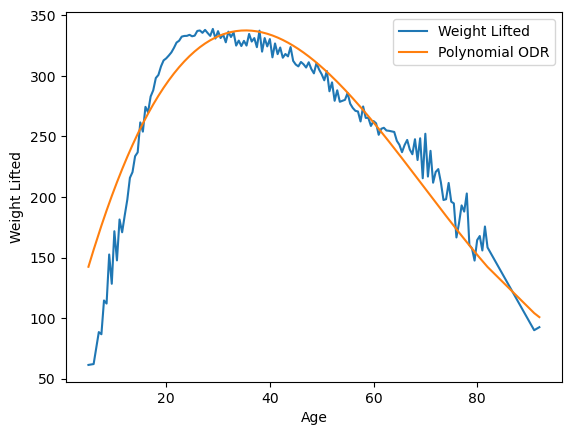

In [65]:
pord(total,'F',3)

Peak Mean Weight Lifted is at: 36.0 years old.
Recovered equation: y=-107.87x + 45.67, t=-2.73, p=7.11e-03
R_Squared: 0.9087958330194444


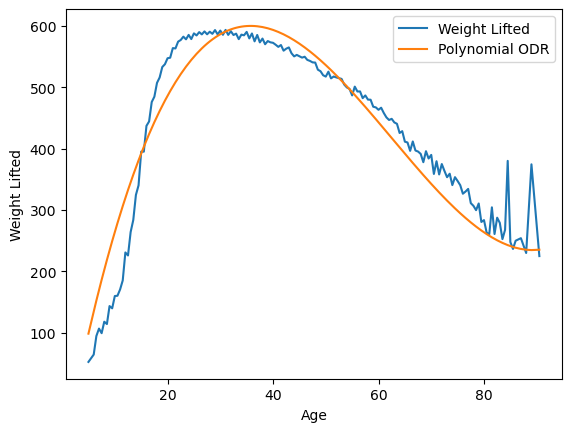

In [66]:
pord(total,'M',3)

Squat

Peak Mean Weight Lifted is at: 34.0 years old.
Recovered equation: y=16.14x + 6.98, t=3.44, p=7.58e-04
R_Squared: 0.903681222815979


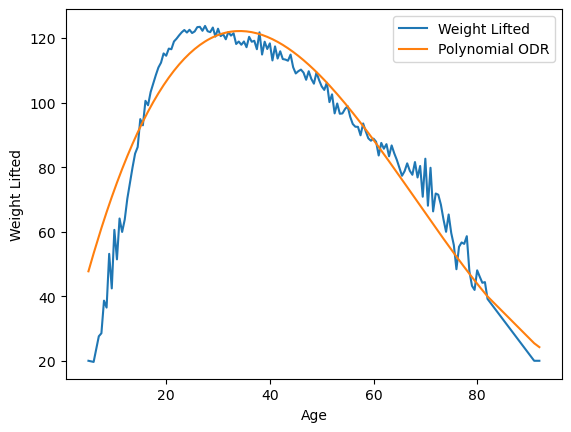

In [67]:
pord(squat,'F',3)

Peak Mean Weight Lifted is at: 35.0 years old.
Recovered equation: y=-39.63x + 16.52, t=-3.02, p=2.98e-03
R_Squared: 0.9085492946888108


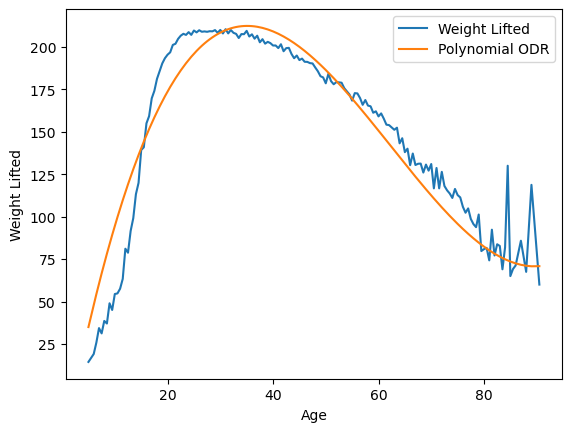

In [68]:
pord(squat,'M',3)

Bench

Peak Mean Weight Lifted is at: 36.5 years old.
Recovered equation: y=2.07x + 4.27, t=0.83, p=4.09e-01
R_Squared: 0.930361560427237


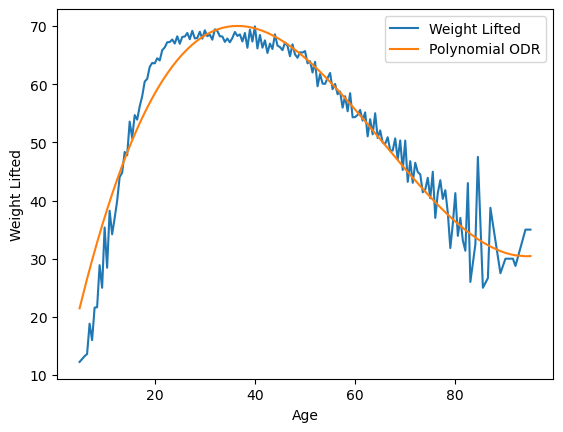

In [69]:
pord(bench,'F',3)

Peak Mean Weight Lifted is at: 39.0 years old.
Recovered equation: y=-19.89x + 9.92, t=-3.60, p=4.09e-04
R_Squared: 0.9307824187572096


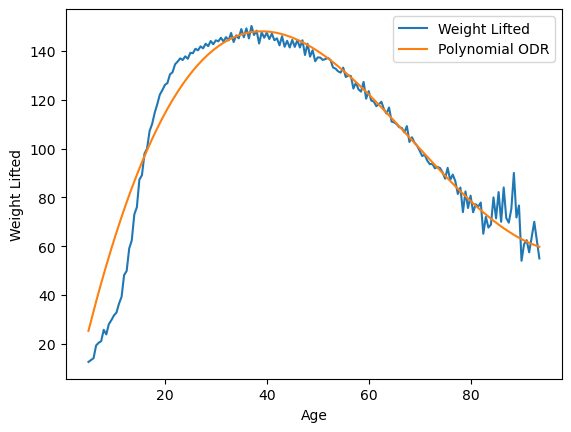

In [70]:
pord(bench,'M',3)

Deadlift

Peak Mean Weight Lifted is at: 37.5 years old.
Recovered equation: y=35.08x + 6.55, t=6.37, p=1.77e-09
R_Squared: 0.8909411892282604


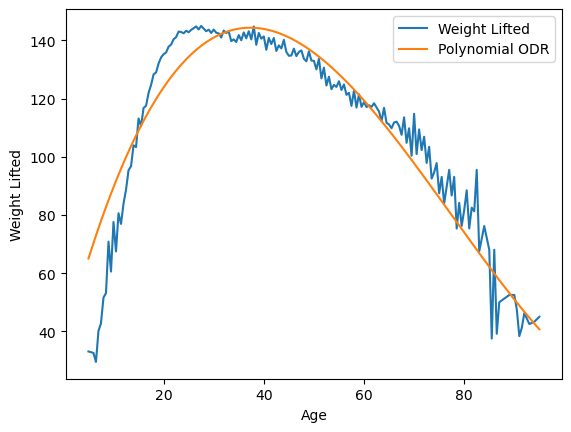

In [71]:
pord(dead,'F',3)

Peak Mean Weight Lifted is at: 36.5 years old.
Recovered equation: y=9.92x + 14.53, t=0.76, p=4.51e-01
R_Squared: 0.8639452674027541


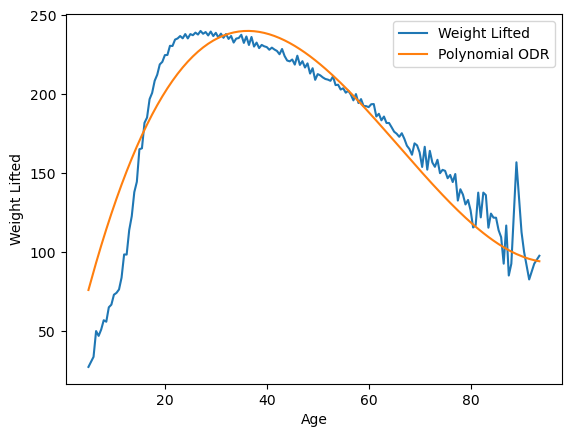

In [72]:
pord(dead,'M',3)

# Export Drug Tested Top Strength Population

Export the dataframe consisting of top 10% strength for each weight group

In [73]:
max_strength_df(total,'M').to_pickle('DT_Total_M.pkl')
max_strength_df(squat,'M').to_pickle('DT_Squat_M.pkl')
max_strength_df(bench,'M').to_pickle('DT_Bench_M.pkl')
max_strength_df(dead,'M').to_pickle('DT_Dead_M.pkl')

max_strength_df(total,'F').to_pickle('DT_Total_F.pkl')
max_strength_df(squat,'F').to_pickle('DT_Squat_F.pkl')
max_strength_df(bench,'F').to_pickle('DT_Bench_F.pkl')
max_strength_df(dead,'F').to_pickle('DT_Dead_F.pkl')